<a href="https://colab.research.google.com/github/JeremyAlain/imitation_learning_from_language_feedback/blob/feature%2Fadd_all_relevant_files/experiments/Results_Training_Language_Models_with_language_feedback_at_Scale_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers
!pip install -Uqq ipdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 775.8/775.8 KB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.4/386.4 KB 24.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython~=7.9.0, but you have ipython 8.8.0 which is incompatible.


In [ ]:
import pandas as pd 
from google.colab import drive 
from typing import List, Union, Dict, Any, Tuple
import os
import numpy as np
from scipy.stats import sem
from matplotlib import pyplot as plt
import seaborn as sns
from transformers import GPT2Tokenizer
import ipdb
from tqdm import tqdm


import matplotlib

root_path = "/content/drive/MyDrive/training_language_models_with_language_feedback_at_scale_public"
fig_output_path = "/content/drive/MyDrive/training_language_models_with_language_feedback_at_scale_public/plots"
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


# Utilities 

In [ ]:
colors = ["#ce776b", "#f3c07d", "#96c79d", "#abd4ff", "#7dc2d1", "#bf86ad", "#a07d6c"]
orange = "#F7A578"

In [ ]:
def calculate_win_rate_of_ranks(ranks: List[int], other_ranks: List[int]) -> Tuple[np.ndarray, np.ndarray]: 
  """Take a list of ranks and calculate the mean win rate and the standard error of the first ranks"""
  assert len(ranks) == len(other_ranks)
  wins = []
  for i in range(len(ranks)): 
    assert isinstance(ranks[i], int) or isinstance(ranks[i], float)
    assert isinstance(other_ranks[i], int) or isinstance(other_ranks[i], float)
    if ranks[i] < other_ranks[i]:
      wins.append(1)
    elif ranks[i] == other_ranks[i]:
      wins.append(0.5)
    elif ranks[i] > other_ranks[i]: 
      wins.append(0)
    else: 
      print("{}, {}".format(ranks[i], other_ranks[i]))
  return np.mean(wins), sem(wins)


In [ ]:
def plot_win_rates_of_methods_compared_to_basline_method(data: pd.DataFrame, method_names_to_evaluate: List[str], baseline_method_names: List[str]):
  results = {}
  for baseline_method_name in baseline_method_names:
    assert baseline_method_name in data.columns, "{} not in {}".format(baseline_method_name, data.columns)
    baseline_method_ranks = data[baseline_method_name].tolist()

    for (method_name_to_evaluate, _) in method_names_to_evaluate:
      assert method_name_to_evaluate in data.columns, "{} not in {}".format(method_name_to_evaluate, data.columns)
      method_to_evaluate_ranks = data[method_name_to_evaluate].tolist()
      current_win_rate_mean, current_win_rate_standard_error = calculate_win_rate_of_ranks(method_to_evaluate_ranks, baseline_method_ranks)

      comparison_title = "{}_vs_{}".format(method_name_to_evaluate, baseline_method_name)

      results[comparison_title] = [current_win_rate_mean, current_win_rate_standard_error]
  results_dataframe = pd.DataFrame(results)
  results_dataframe.index = ["Win Rate Mean", "Win Rate Standard Error"]
  return results_dataframe.T

In [ ]:
def add_linebreaks(text, max_line=12):
  words = text.split()
  new_text = ""
  current_line_len = 0
  for word in words:
    word = " " + word
    if current_line_len + len(word) > max_line:
      new_text += '\n' + word
      current_line_len = len(word)
    else:
      new_text += word
      current_line_len += len(word)
  return new_text

In [ ]:
def calculate_tokens(list_of_texts: List[str]) -> Tuple[List[str], List[str]]: 
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    all_tokens = []
    all_token_lengths = []
    for text in list_of_texts: 
        tokens = tokenizer(text)["input_ids"]
        all_tokens.append(tokens)
        all_token_lengths.append(len(tokens))
    return all_tokens, all_token_lengths
    

Note that initially the Train dataset had 5500 samples where we concatenated ~4900 train samples with 500 samples that were initially meant as a validation dataset (and were thus gathered in a different data collection). 

Those additional 500 samples were meant as a reserve for some experiments, but we never really used them. So when we use the 5K dataset that's basically concatinating those two datasets and selecting the first 5K sampes. This is what we did everywhere. on huggingface and the google drive you will see the final train dataset with only 5K samples. However some of the results are on the 5500 samples, so we usually shorten those results datasets to 5000 samples so that we have the same ones everywhere.

# Train dataset - Number of tokens of Ideal, Initial, Selected refinement and feedback

In [ ]:
train_data = pd.read_json(os.path.join(root_path, "final_dataset/train_dataset_5000.jsonl"), lines=True)

In [ ]:
_, number_of_tokens_in_ideal_human_summary = calculate_tokens(train_data["ideal_human_summary"])
_, nmber_of_tokens_in_feedback = calculate_tokens(train_data["feedback"])
_, number_of_tokens_in_initial_summary = calculate_tokens(train_data["generated_summary_for_feedback"])
_, number_of_tokens_of_tldr_reference_summary = calculate_tokens(train_data["tldr_human_reference_summary"])

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [ ]:
print("Average number of tokens in human summaries: {} +/- {}".format(np.mean(number_of_tokens_in_ideal_human_summary), sem(number_of_tokens_in_ideal_human_summary)))
print("Average number of tokens in feedback: {} +/- {}".format(np.mean(nmber_of_tokens_in_feedback), sem(nmber_of_tokens_in_feedback)))
print("Average number of tokens in initial summaries: {} +/- {}".format(np.mean(number_of_tokens_in_initial_summary), sem(number_of_tokens_in_initial_summary)))
print("Average number of tokens in tldr_reference_summaries: {} +/- {}".format(np.mean(number_of_tokens_of_tldr_reference_summary), sem(number_of_tokens_of_tldr_reference_summary)))

Average number of tokens in human summaries: 40.997 +/- 0.10199352300880263
Average number of tokens in feedback: 20.3888 +/- 0.1529016765654952
Average number of tokens in initial summaries: 29.334 +/- 0.13581317257014766
Average number of tokens in tldr_reference_summaries: 32.5478 +/- 0.09023819378912493


In [ ]:
selected_refinements = pd.read_json("/content/drive/MyDrive/training_language_models_with_language_feedback_at_scale_public/results/feedback_refinement_train_5489_with_selected_refinements_causal_response_ensemble.jsonl", lines=True)
selected_refinements = selected_refinements.iloc[:5000]
assert selected_refinements["id"].tolist() == train_data["id"].tolist()

In [ ]:
_, number_of_tokens_in_selected_refinements = calculate_tokens(selected_refinements["causal_response_ensemble_selected_refinement"])

In [ ]:
print("Average number of tokens in selected refinements: {} +/- {}".format(np.mean(number_of_tokens_in_selected_refinements), sem(number_of_tokens_in_selected_refinements)))

Average number of tokens in selected refinements: 35.5662 +/- 0.1082269195959353


# Plotting Development Dataset Results

## Average Time for 1 Annotation Type

In [ ]:
development_dataset = pd.read_json("/content/drive/MyDrive/training_language_models_with_language_feedback_at_scale_public/final_dataset/development_dataset_200.jsonl", lines=True)
method_names_timing = [("feedback", "Feedback"), ("ideal_human_summary", "Human Summary"), ("comparison", "Binary Comparison")]
assert development_dataset.shape[0] == 200

In [ ]:
def plot_time_measurements_for_annotation(dataset: pd.DataFrame, method_name: str, title: str, color, minimum_timing:int=0, maximum_timing:int=1000,use_median: bool=True, remove_x_label:bool=False, remove_y_label: bool=False) -> None: 
  times_per_annotation = dataset["time_spent_in_seconds_{}".format(method_name)]
  sorted_times_per_annotation = times_per_annotation.sort_values()
  sorted_times_per_annotation_in_range_indices = sorted_times_per_annotation.between(minimum_timing, maximum_timing, inclusive="both")
  sorted_times_per_annotation_in_range = sorted_times_per_annotation[sorted_times_per_annotation_in_range_indices]

  sorted_times_per_annotation_in_range.hist(bins=50, color=color)
  if not remove_x_label: 
  #  ax.axes.get_xaxis().set_visible(False)
    plt.xlabel("Annotation Time (seconds)")
  if not remove_y_label: 
  #  ax.axes.get_yaxis().set_visible(False)
    plt.ylabel("Bin count")

  plt.title("{} Annotations".format(title), fontsize=14)
  
  if use_median: 
    average = sorted_times_per_annotation_in_range.median()
  else: 
    average = sorted_times_per_annotation_in_range.mean()
  
  plt.axvline(average, color="black", linestyle="solid", linewidth=1)
  ax = plt.gca()
  #ax.grid(visible=True, which="both")
  if use_median: 
    plt.text(0.99, 0.99, 'Median Time: {:.2f}'.format(average), color="black", bbox=dict(alpha=0.3, facecolor="wheat"),ha="right", va="top",  transform=ax.transAxes,)
    print("Median time {} +/- {}".format(average, sem(sorted_times_per_annotation_in_range.tolist())))
  else: 
    plt.text(0.99, 0.99, 'Mean Time: {:.2f}'.format(average), color="black", bbox=dict(alpha=0.3, facecolor="wheat"),ha="right", va="top",  transform=ax.transAxes,)
    print("Mean time {} +/- {}".format(average, sem(sorted_times_per_annotation_in_range.tolist())))

  
  plt.savefig(fig_output_path+ f"/human_annotation_time_{title}.pdf", bbox_inches='tight')
  plt.show()



Median time 182.5 +/- 6.348133158293673


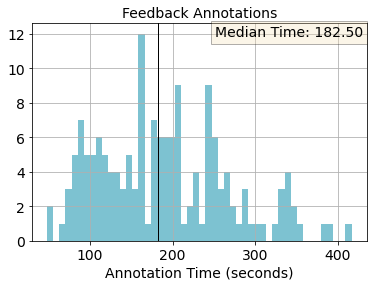

Median time 195.5 +/- 6.075697352452492


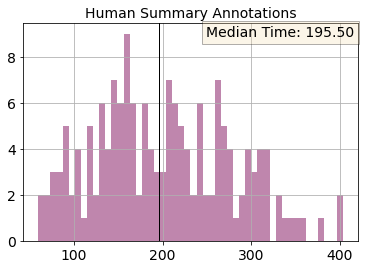

Median time 61.5 +/- 5.252584465651051


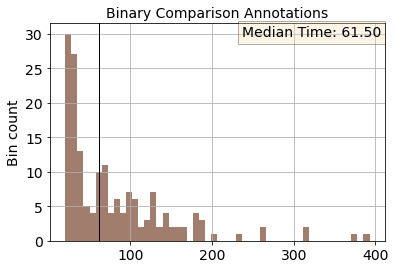

In [ ]:
params = {'font.size': 14, 'axes.labelsize': 14, 'legend.fontsize': 12, 'xtick.labelsize': 14, 'ytick.labelsize': 14}
matplotlib.rcParams.update(params)
for (method_name, title) in method_names_timing: 
  if method_name == "feedback": 
    color = colors[-3]
    plot_time_measurements_for_annotation(development_dataset, method_name, title, minimum_timing=20, maximum_timing=420, color=color, remove_x_label=False, remove_y_label=True)
  elif method_name == "ideal_human_summary": 
    color = colors[-2]
    plot_time_measurements_for_annotation(development_dataset, method_name, title, minimum_timing=20, maximum_timing=420, color=color, remove_x_label=True, remove_y_label=True)
  else: 
    color = colors[-1]
    plot_time_measurements_for_annotation(development_dataset, method_name, title, minimum_timing=20, maximum_timing=420, color=color, remove_x_label=True, remove_y_label=False)

## Average time per tokens for Annoation time

In [ ]:
development_dataset = pd.read_json("/content/drive/MyDrive/training_language_models_with_language_feedback_at_scale_public/final_dataset/development_dataset_200.jsonl", lines=True)
method_names_timing_per_token = [("feedback", "Feedback"), ("ideal_human_summary", "Human Summary")]
assert development_dataset.shape[0] == 200

In [ ]:
def plot_time_measurements_per_token_for_annotation(dataset: pd.DataFrame, method_name: str, title: str, color, minimum_timing:int=0, maximum_timing:int=1000,use_median: bool=True) -> None: 
  _, token_length_per_text = calculate_tokens(dataset[method_name].tolist())
  dataset["token_length_per_text"] = token_length_per_text
  print("Average Numer of tokens: {}".format(dataset["token_length_per_text"].mean()))
  
  times_per_annotation = dataset["time_spent_in_seconds_{}".format(method_name)]
  sorted_times_per_annotation = times_per_annotation.sort_values()
  sorted_times_per_annotation_in_range_indices = sorted_times_per_annotation.between(minimum_timing, maximum_timing, inclusive="both")
  
  sorted_dataset_in_range = dataset[sorted_times_per_annotation_in_range_indices]
  average_timing_per_token_length = sorted_dataset_in_range.groupby("token_length_per_text")["time_spent_in_seconds_{}".format(method_name)].mean().reset_index()

  fig, ax = plt.subplots()
  plt.bar(average_timing_per_token_length["token_length_per_text"], average_timing_per_token_length["time_spent_in_seconds_{}".format(method_name)], color=color)
  plt.xlabel("Token Length")
  plt.ylabel("Annotation Time (seconds)")
  plt.title("{} Annotations".format(title))
  
  if use_median: 
    average = average_timing_per_token_length["token_length_per_text"].median()
  else: 
    average = average_timing_per_token_length["token_length_per_text"].mean()
  
  plt.axvline(average, color="black", linestyle="solid", linewidth=1)
  _, max_ylim = plt.ylim()
  if use_median: 
    plt.text(0.01, .99, 'Median Token Length: {:.2f}'.format(average), color="black", bbox=dict(alpha=0.3, facecolor="wheat"),ha="left", va="top",  transform=ax.transAxes,)
  else: 
    plt.text(0.7*average, max_ylim*0.95, 'Mean Token Length: {:.2f}'.format(average), color="black", bbox=dict(alpha=0.3, facecolor="wheat"),)
  plt.show()

  #average_times_per_single_tokens = []
  #for i in range(average_timing_per_token_length.shape[0]): 
  #  current_average_time_for_token_length = average_timing_per_token_length.iloc[i]["time_spent_in_seconds_{}".format(method_name)]
  #  current_token_length = average_timing_per_token_length.iloc[i]["token_length_per_text"]
  #  average_times_per_single_tokens.append(float(current_average_time_for_token_length/current_token_length))

  #average_time_per_single_token = np.mean(average_times_per_single_tokens)
  #print("Avarage time for single token across various token lengths: {} +/- {}".format(average_time_per_single_token, sem(average_times_per_single_tokens)))


Average Numer of tokens: 35.78


<ipython-input-18-8c85452f9704>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sorted_dataset_in_range = dataset[sorted_times_per_annotation_in_range_indices]


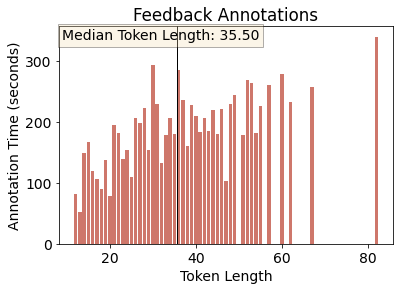

Average Numer of tokens: 38.415


<ipython-input-18-8c85452f9704>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sorted_dataset_in_range = dataset[sorted_times_per_annotation_in_range_indices]


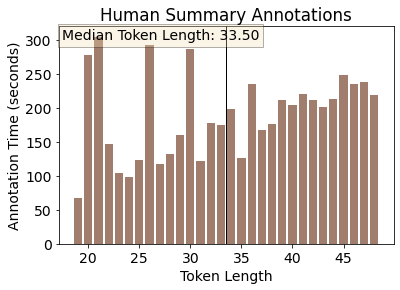

In [ ]:
for (method_name, title) in method_names_timing_per_token: 
  if method_name == "feedback": 
    color = colors[0]
  elif method_name == "ideal_human_summary": 
    color = colors[-1]
  else: 
    raise NotImplementedError()
  plot_time_measurements_per_token_for_annotation(development_dataset, method_name, title,minimum_timing=20, maximum_timing=420, color=color)

# Comparing Human Annotation Quality to Openai's Dataset

In [ ]:
ideal_vs_reference_data = pd.read_json("/content/drive/MyDrive/training_language_models_with_language_feedback_at_scale_public/results/openai_tldr_vs_surge_ideal_human_with_wins.json", lines=True)
print("ideal human summaries surge average wins {} +/- {}".format(ideal_vs_reference_data["ideal_human_summary_wins"].mean(), sem(ideal_vs_reference_data["ideal_human_summary_wins"])))
print("tldr reference summaries openai average wins {} +/- {}".format(ideal_vs_reference_data["tldr_human_reference_summary_wins"].mean(), sem(ideal_vs_reference_data["tldr_human_reference_summary_wins"])))
# old results were at 74% win rate

ideal human summaries surge average wins 0.72 +/- 0.031828687164775826
tldr reference summaries openai average wins 0.28 +/- 0.031828687164775826


# Plotting Validation Dataset Results

### Comparing Refinement Methods

In [ ]:
comparing_refinements_results = pd.read_json("/content/drive/MyDrive/training_language_models_with_language_feedback_at_scale_public/results/validation_500_refinement_methods_comparison_with_ranking_per_refinement.json", lines=True)
comparing_refinements_results.shape

(500, 32)

In [ ]:
refinement_comparision_validation_methods_to_evaluate = [("ideal_human_summary_rank", "Human Summaries"),
                                                          ("direct_refinement_rank", "Refinement (w/o Feedback)"), 
                                                         ("random_selected_refinement_rank", "Refine w/ Feedback"), 
                                                          ("causal_response_ensemble_selected_refinement_rank", "Refine w/ Feedback + Best-of-5"),

                                                         ]
refinement_comparison_validation_baselines = ["generated_summary_for_feedback_rank"]
refinement_comparison_validation_results = plot_win_rates_of_methods_compared_to_basline_method(comparing_refinements_results, 
                                                                                                refinement_comparision_validation_methods_to_evaluate,
                                                                                                refinement_comparison_validation_baselines
                                                                                                )

In [ ]:
refinement_comparison_validation_results

,Win Rate Mean,Win Rate Standard Error
ideal_human_summary_rank_vs_generated_summary_for_feedback_rank,0.832,0.016677
direct_refinement_rank_vs_generated_summary_for_feedback_rank,0.594,0.020668
random_selected_refinement_rank_vs_generated_summary_for_feedback_rank,0.639,0.020179
causal_response_ensemble_selected_refinement_rank_vs_generated_summary_for_feedback_rank,0.691,0.019463


In [ ]:
refinement_comparision_validation_methods_to_evaluate2 = [("causal_response_ensemble_selected_refinement_rank", "Refine w/ Feedback + Best-of-5"),
                                                         ("random_selected_refinement_rank", "Refine w/ Feedback"), 
                                                         ("direct_refinement_rank", "Direct Refinement (w/o Feedback)"), 
                                                         ("ideal_human_summary_rank", "Human Summaries")]
refinement_comparison_validation_baselines2 = ["ideal_human_summary_rank"]
refinement_comparison_validation_results2 = plot_win_rates_of_methods_compared_to_basline_method(comparing_refinements_results, 
                                                                                                refinement_comparision_validation_methods_to_evaluate2,
                                                                                                refinement_comparison_validation_baselines2
                                                                                                )

In [ ]:
refinement_comparison_validation_results2

,Win Rate Mean,Win Rate Standard Error
causal_response_ensemble_selected_refinement_rank_vs_ideal_human_summary_rank,0.303,0.020548
random_selected_refinement_rank_vs_ideal_human_summary_rank,0.306,0.020483
direct_refinement_rank_vs_ideal_human_summary_rank,0.266,0.019730
ideal_human_summary_rank_vs_ideal_human_summary_rank,0.500,0.000000


In [ ]:
def plot_refinements_comparison_validation_results(results_dataframe: pd.DataFrame, method_names: List[str]): 
  # assume methos are on rows in results dataframe
  win_rates = [100*win_rate for win_rate in results_dataframe["Win Rate Mean"].tolist()]
  standard_error = [100*standard_error for standard_error in results_dataframe["Win Rate Standard Error"].tolist()]

  x_axis = range(results_dataframe.shape[0])
  fig, ax = plt.subplots()
  color = colors[:4]
  ax.barh(x_axis,win_rates , xerr=standard_error, color=color[::-1])
  #ax.axhline(y=50, color='black', linestyle='--')
  #ax.text(2.1, 45, "Initial Summaries")
  plt.xlabel("Win Rate vs. \n Initial Summaries (%)")
  method_titles = [add_linebreaks(title) for (_, title) in method_names]
  plt.yticks(x_axis, method_titles, rotation=0)
  plt.xlim((50))
  plt.savefig(fig_output_path+ f"/validation_500_refinement_method_comparison.pdf", bbox_inches='tight')
  plt.show()

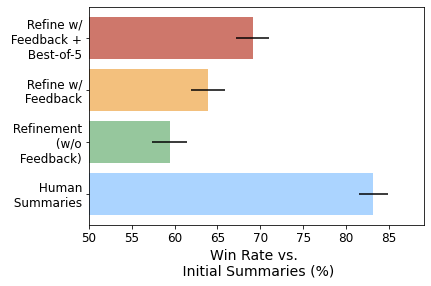

In [ ]:
params = {'font.size': 12, 'axes.labelsize': 14, 'legend.fontsize': 20, 'xtick.labelsize': 12, 'ytick.labelsize': 12}
matplotlib.rcParams.update(params)
plot_refinements_comparison_validation_results(refinement_comparison_validation_results, refinement_comparision_validation_methods_to_evaluate)

### Is Feedback Incorporated

In [ ]:
is_feedback_incorporated_results_path = "/content/drive/MyDrive/training_language_models_with_language_feedback_at_scale_public/results/validation_500_refinement_methods_is_feedback_incorporated.json"
is_feedback_incorporated_results = pd.read_json(is_feedback_incorporated_results_path, lines=True)
is_feedback_incorporated_results.shape

(500, 29)

In [ ]:
is_feedback_incorporated_method_name_pairs = [
    ("ideal_human_summary_is_feedback_incorporated", "Human Summaries"), 
    ("direct_refinement_is_feedback_incorporated", "Direct Refinement (w/o Feedback)"),
    ("random_selected_refinement_is_feedback_incorporated", "Refine w/ Feedback"),
    ("causal_response_ensemble_selected_refinement_is_feedback_incorporated", "Refine w/ Feedback + Best-of-5"), 
]

In [ ]:
def calculate_feedback_incorporation_rate(data: pd.DataFrame, column_names: List[str]) -> pd.DataFrame: 
  results = {}
  for column_name in column_names:
    is_feedback_incorporated_for_method =  is_feedback_incorporated_results[column_name].map(dict(Yes=1, No=0)).tolist()
    for element in is_feedback_incorporated_for_method: 
      assert element == 0 or element == 1, element
    is_feedback_incorporated_mean = np.mean(is_feedback_incorporated_for_method)
    is_feedback_incorporated_standard_error = sem(is_feedback_incorporated_for_method)
    results[column_name] = [is_feedback_incorporated_mean, is_feedback_incorporated_standard_error]

  results_dataframe = pd.DataFrame(results)
  results_dataframe.index = ["Feedback Incorporation Rate Mean", "Feedback Incorporation Rate Standard Error"]
  return results_dataframe.T

In [ ]:
column_names = [column_name for (column_name, _ ) in is_feedback_incorporated_method_name_pairs]
is_feedback_incorporated_results = calculate_feedback_incorporation_rate(is_feedback_incorporated_results, column_names)
is_feedback_incorporated_results

,Feedback Incorporation Rate Mean,Feedback Incorporation Rate Standard Error
ideal_human_summary_is_feedback_incorporated,0.740,0.019636
direct_refinement_is_feedback_incorporated,0.308,0.020667
random_selected_refinement_is_feedback_incorporated,0.496,0.022382
causal_response_ensemble_selected_refinement_is_feedback_incorporated,0.574,0.022137


In [ ]:
def plot_is_feedback_incorporated(results_dataframe: pd.DataFrame, method_names) -> None: 
  win_rates = [100*win_rate for win_rate in results_dataframe["Feedback Incorporation Rate Mean"].tolist()]
  standard_error = [100*standard_error for standard_error in results_dataframe["Feedback Incorporation Rate Standard Error"].tolist()]
  x_axis = range(results_dataframe.shape[0])
  fig, ax = plt.subplots()
  color = colors[:4]
  ax.barh(x_axis,win_rates , xerr=standard_error, color=color[::-1])
  plt.xlabel("% of summaries \n incorporating most important \n feedback point")
  #plt.xlabel("Most important feedback points incorporated")
  method_titles = [add_linebreaks(title) for (_, title) in method_names]
  plt.yticks(x_axis, method_titles, rotation=0)
  plt.savefig(fig_output_path+ f"/validation_500_refinement_methods_is_feedback_incorporated.pdf", bbox_inches='tight')
  plt.show()

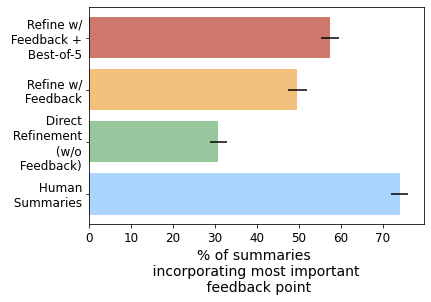

In [ ]:
plot_is_feedback_incorporated(is_feedback_incorporated_results, is_feedback_incorporated_method_name_pairs)

# GPT-3 Reward Model Result

## Comparison Reward model

In [ ]:
comparison_reward_model_results_path = "/content/drive/MyDrive/training_language_models_with_language_feedback_at_scale_public/results/reward_model_500_validation_comparison_dataset_predictions.jsonl"
comparison_reward_model_results = pd.read_json(comparison_reward_model_results_path, lines=True)
comparison_reward_model_results.shape

(500, 3)

In [ ]:
def calculate_comparison_accuracy(normalizd_A_probabilities: List[str], targets: List[str]): 
  correct_predictions = []
  assert len(normalizd_A_probabilities) == len(targets)
  sample_count = len(normalizd_A_probabilities)
  assert sample_count == 500
  for i in range(sample_count):
    target = targets[i]
    if normalizd_A_probabilities[i] >= 0.5:
      if target == " A": 
        correct_predictions.append(1)
      elif target == " B": 
        correct_predictions.append(0)
      else: 
        raise ValueError()
    else: 
      if target == " A": 
        correct_predictions.append(0)
      elif target == " B": 
        correct_predictions.append(1)
      else: 
        raise ValueError()
  return np.mean(correct_predictions), sem(correct_predictions), correct_predictions


In [ ]:
targets = comparison_reward_model_results["completion"].tolist()
normalizd_A_probabilities = comparison_reward_model_results["normalized_A_probability"].tolist()

In [ ]:
accuracy_mean, accuracy_standard_error, correct_predictions = calculate_comparison_accuracy(normalizd_A_probabilities=normalizd_A_probabilities, targets=targets)
print("Comparison Reward Model Evaluation on Validation Dataset 500")
print("Accuracy Mean: {} +/- {}".format(accuracy_mean, accuracy_standard_error))

Comparison Reward Model Evaluation on Validation Dataset 500
Accuracy Mean: 0.712 +/- 0.020271503835075255


In [ ]:
comparison_reward_model_results["completion"].value_counts()

 A    258
 B    242
Name: completion, dtype: int64

In [ ]:
np.sum(correct_predictions)

356

## Classification Reward Model

In [ ]:
classification_reward_model_results_path = "/content/drive/MyDrive/training_language_models_with_language_feedback_at_scale_public/results/reward_model_500_validation_classification_dataset_predictions.jsonl"
classification_reward_model_results = pd.read_json(classification_reward_model_results_path, lines=True)
classification_reward_model_results.shape

(1000, 3)

In [ ]:
def calculate_classification_accuracy(normalized_yes_probability_predictions: List[str], targets: List[str]): 
  correct_predictions = []
  assert len(normalized_yes_probability_predictions) == len(targets)
  sample_count = len(normalized_yes_probability_predictions) // 2
  assert sample_count == 500
  for i in range(sample_count):
    first_summary_yes_prob = normalized_yes_probability_predictions[2*i]
    second_summary_yes_prob = normalized_yes_probability_predictions[2*i+1]

    first_target = targets[2*i]
    second_target = targets[2*i+1]

    assert (first_target == " Yes" and second_target == " No") or (first_target== " No" and second_target == " Yes")
    if first_summary_yes_prob >= second_summary_yes_prob: 
      if first_target == " Yes": 
        correct_predictions.append(1)
      elif first_target == " No": 
        correct_predictions.append(0)
      else: 
        raise ValueError()
    else: 
      if second_target == " Yes": 
        correct_predictions.append(1)
      elif second_target == " No": 
        correct_predictions.append(0)
      else: 
        raise ValueError()
  return np.mean(correct_predictions), sem(correct_predictions), correct_predictions


In [ ]:
for i in range(classification_reward_model_results.shape[0]//2):
  assert classification_reward_model_results["prompt"][2*i].split("TL;DR")[0] == classification_reward_model_results["prompt"][2*i+1].split("TL;DR")[0]

In [ ]:
normalized_yes_probability_predictions = classification_reward_model_results["normalized_yes_probability"].tolist()
targets = classification_reward_model_results["completion"].tolist()
accuracy_mean, accuracy_standard_error, correct_predictions = calculate_classification_accuracy(normalized_yes_probability_predictions=normalized_yes_probability_predictions, targets=targets)
print("Classificaiton Reward Model Evaluation on Validation Dataset 500")
print("Accuracy Mean: {} +/- {}".format(accuracy_mean, accuracy_standard_error))

Classificaiton Reward Model Evaluation on Validation Dataset 500
Accuracy Mean: 0.742 +/- 0.019586711785215868


# OPT Reward Model (Classification Prompt) - Scaling Plot

Results are copied from [here](https://docs.google.com/spreadsheets/d/1xQrN46KAQxqMrE73KyK21ymNB6kg9Gw8kfAxhO_J_6k/edit#gid=0ps://)

In [ ]:
# validaiton accuracy plus standard error
reward_model_results = {
    "openai_rm": [63.8, 2.1] ,
    "opt_rm": [71.8, 2.0] ,
    "opt_classification_100": [53.4, 2.2],
    "opt_classification_1K": [67.2, 2.1], 
    "opt_classification_5K": [73.4, 1.9], 
    "opt_classification_90K_openai_data": [68.0, 2.0],
    "opt_comparison_5K": [72.6, 1.9], 
    "gpt3_comparison":  [71.2, 2.0], 
    "gpt3_classification": [74.2, 2.0]
}

In [ ]:
from matplotlib.ticker import ScalarFormatter

def plot_reward_model_results(results: pd.DataFrame):
  markersize = 7
  fig, ax = plt.subplots()
  x_values = [100, 1000, 5000]

  opt_classification_mean = [results["opt_classification_100"][0], results["opt_classification_1K"][0], results["opt_classification_5K"][0]]
  opt_classificaiton_sem = [results["opt_classification_100"][1], results["opt_classification_1K"][1], results["opt_classification_5K"][1]]
  plt.plot(x_values, opt_classification_mean, label="OPT 13B Classification Prompt (LM Loss)", color=colors[-2],marker="o")
  ax.fill_between(x_values,
                  np.array(opt_classification_mean)-np.array(opt_classificaiton_sem),
                  np.array(opt_classification_mean)+np.array(opt_classificaiton_sem),
                  alpha=0.2, color=colors[-2])

  plt.xlabel("Train Dataset Size")
  plt.ylabel("Accuracy in %)")
  plt.xscale("log")
  plt.yscale("log")
  ax.set_xticks([100, 1000, 5000])
  ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

  ax.set_yticks([50, 60, 70])
  ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
  plt.savefig(fig_output_path+ f"/opt_13B_classification_rm_scaling_plot.pdf", bbox_inches='tight')
  plt.show()

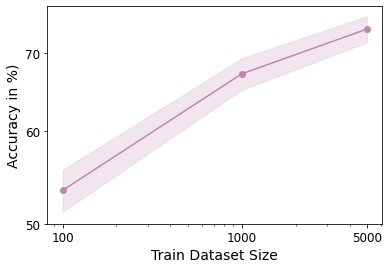

In [ ]:
plot_reward_model_results(reward_model_results)

# Comparing Finetuned Methods

## 100

In [ ]:
comparing_finetuned_results_100 = pd.read_json("/content/drive/MyDrive/training_language_models_with_language_feedback_at_scale_public/results/test_dataset_comparison_of_finetuned_models_100_with_ranking_per_summary.json", lines=True)
comparing_finetuned_results_100.shape

(698, 33)

In [ ]:
finetuning_methods_to_evaluate_100 = [("finetuned_100_refinements_generated_summary_rank", "Davinci Finetuned on 100 Refinements"),
                                                         ("finetuned_100_human_generated_summary_rank", "Davinci Finetuned on 100 Human Summaries"), 
                                                         ("finetuned_100_initial_generated_summary_rank", "Davinci Finetuned on 100 Initial Summaries"), 
                                                         ("opt_reward_model_100_selected_summary_rank", "OPT Reward Model 13B - 100 Datapoints"), 
                                                         ("text_davinci_001_generated_summary_rank", "text-davinci-001"), 
                                                         ("ideal_human_summary_rank", "Human Summaries")]
finetuning_methods_results_100 = plot_win_rates_of_methods_compared_to_basline_method(comparing_finetuned_results_100, 
                                                                                                finetuning_methods_to_evaluate_100,
                                                                                                ["ideal_human_summary_rank"]
                                                                                                )
finetuning_methods_results_100

,Win Rate Mean,Win Rate Standard Error
finetuned_100_refinements_generated_summary_rank_vs_ideal_human_summary_rank,0.196275,0.015010
finetuned_100_human_generated_summary_rank_vs_ideal_human_summary_rank,0.168338,0.014118
finetuned_100_initial_generated_summary_rank_vs_ideal_human_summary_rank,0.196275,0.015044
opt_reward_model_100_selected_summary_rank_vs_ideal_human_summary_rank,0.255014,0.016479
text_davinci_001_generated_summary_rank_vs_ideal_human_summary_rank,0.207736,0.015366
ideal_human_summary_rank_vs_ideal_human_summary_rank,0.500000,0.000000


In [ ]:
for (name, _) in finetuning_methods_to_evaluate_100:
  print("{}: {}".format(name, comparing_finetuned_results_100[name].mean()))

finetuned_100_refinements_generated_summary_rank: 3.9498567335243555
finetuned_100_human_generated_summary_rank: 4.149713467048711
finetuned_100_initial_generated_summary_rank: 3.8302292263610314
opt_reward_model_100_selected_summary_rank: 3.339541547277937
text_davinci_001_generated_summary_rank: 3.70702005730659
ideal_human_summary_rank: 2.023638968481375


In [ ]:
finetuning_methods_to_evaluate_1002 = [("finetuned_100_refinements_generated_summary_rank", "Davinci Finetuned on 100 Refinements"),
                                                         ("finetuned_100_human_generated_summary_rank", "Davinci Finetuned on 100 Human Summaries"), 
                                                         ("finetuned_100_initial_generated_summary_rank", "Davinci Finetuned on 100 Initial Summaries"), 
                                                         ("opt_reward_model_100_selected_summary_rank", "OPT Reward Model 13B - 100 Datapoints"), 
                                                         ("text_davinci_001_generated_summary_rank", "text-davinci-001"), 
                                                         ("ideal_human_summary_rank", "Human Summaries")]
finetuning_methods_results_100_vs_initial2 = plot_win_rates_of_methods_compared_to_basline_method(comparing_finetuned_results_100, 
                                                                                                finetuning_methods_to_evaluate_1002,
                                                                                                ["finetuned_100_initial_generated_summary_rank"]
                                                                                                )
finetuning_methods_results_100_vs_initial2

,Win Rate Mean,Win Rate Standard Error
finetuned_100_refinements_generated_summary_rank_vs_finetuned_100_initial_generated_summary_rank,0.488539,0.018660
finetuned_100_human_generated_summary_rank_vs_finetuned_100_initial_generated_summary_rank,0.449140,0.018635
finetuned_100_initial_generated_summary_rank_vs_finetuned_100_initial_generated_summary_rank,0.500000,0.000000
opt_reward_model_100_selected_summary_rank_vs_finetuned_100_initial_generated_summary_rank,0.576648,0.018674
text_davinci_001_generated_summary_rank_vs_finetuned_100_initial_generated_summary_rank,0.512178,0.018756
ideal_human_summary_rank_vs_finetuned_100_initial_generated_summary_rank,0.803725,0.015044


In [ ]:
finetuning_methods_to_evaluate_1003 = [("finetuned_100_refinements_generated_summary_rank", "Davinci Finetuned on 100 Refinements"),
                                                         ("finetuned_100_human_generated_summary_rank", "Davinci Finetuned on 100 Human Summaries"), 
                                                         ("finetuned_100_initial_generated_summary_rank", "Davinci Finetuned on 100 Initial Summaries"), 
                                                         ("opt_reward_model_100_selected_summary_rank", "OPT Reward Model 13B - 100 Datapoints"), 
                                                         ("text_davinci_001_generated_summary_rank", "text-davinci-001"), 
                                                         ("ideal_human_summary_rank", "Human Summaries")]
finetuning_methods_results_100_vs_human3 = plot_win_rates_of_methods_compared_to_basline_method(comparing_finetuned_results_100, 
                                                                                                finetuning_methods_to_evaluate_1003,
                                                                                                ["finetuned_100_human_generated_summary_rank"]
                                                                                                )
finetuning_methods_results_100_vs_human3

,Win Rate Mean,Win Rate Standard Error
finetuned_100_refinements_generated_summary_rank_vs_finetuned_100_human_generated_summary_rank,0.547278,0.018662
finetuned_100_human_generated_summary_rank_vs_finetuned_100_human_generated_summary_rank,0.500000,0.000000
finetuned_100_initial_generated_summary_rank_vs_finetuned_100_human_generated_summary_rank,0.550860,0.018635
opt_reward_model_100_selected_summary_rank_vs_finetuned_100_human_generated_summary_rank,0.631805,0.018099
text_davinci_001_generated_summary_rank_vs_finetuned_100_human_generated_summary_rank,0.588109,0.018573
ideal_human_summary_rank_vs_finetuned_100_human_generated_summary_rank,0.831662,0.014118


## 1K

In [ ]:
comparing_finetuned_results_1k = pd.read_json("/content/drive/MyDrive/training_language_models_with_language_feedback_at_scale_public/results/test_dataset_comparison_of_finetuned_models_1K_with_ranking_per_summary.json", lines=True)
comparing_finetuned_results_1k.shape

(698, 33)

In [ ]:
finetuning_comparision_validation_methods_to_evaluate_1k = [("finetuned_1K_refinements_generated_summary_rank", "Davinci Finetuned on 1K Refinements"),
                                                         ("finetuned_1K_human_generated_summary_rank", "Davinci Finetuned on 1K Human Summaries"), 
                                                         ("finetuned_1K_initial_generated_summary_rank", "Davinci Finetuned on 1K Initial Summaries"), 
                                                         ("opt_reward_model_1K_selected_summary_rank", "OPT Reward Model 13B - 1K Datapoints"), 
                                                         ("text_davinci_001_generated_summary_rank", "text-davinci-001"), 
                                                         ("ideal_human_summary_rank", "Human Summaries")]
finetuning_methods_results_1K = plot_win_rates_of_methods_compared_to_basline_method(comparing_finetuned_results_1k, 
                                                                                                finetuning_comparision_validation_methods_to_evaluate_1k,
                                                                                                ["ideal_human_summary_rank"]
                                                                                                )
finetuning_methods_results_1K

,Win Rate Mean,Win Rate Standard Error
finetuned_1K_refinements_generated_summary_rank_vs_ideal_human_summary_rank,0.291547,0.017080
finetuned_1K_human_generated_summary_rank_vs_ideal_human_summary_rank,0.262894,0.016628
finetuned_1K_initial_generated_summary_rank_vs_ideal_human_summary_rank,0.250716,0.016323
opt_reward_model_1K_selected_summary_rank_vs_ideal_human_summary_rank,0.419771,0.018611
text_davinci_001_generated_summary_rank_vs_ideal_human_summary_rank,0.239255,0.016096
ideal_human_summary_rank_vs_ideal_human_summary_rank,0.500000,0.000000


In [ ]:
for (name, _) in finetuning_comparision_validation_methods_to_evaluate_1k:
  print("{}: {}".format(name, comparing_finetuned_results_1k[name].mean()))

finetuned_1K_refinements_generated_summary_rank: 3.7392550143266474
finetuned_1K_human_generated_summary_rank: 4.034383954154728
finetuned_1K_initial_generated_summary_rank: 3.9548710601719197
opt_reward_model_1K_selected_summary_rank: 2.75
text_davinci_001_generated_summary_rank: 4.0573065902578795
ideal_human_summary_rank: 2.464183381088825


In [ ]:
finetuning_methods_to_evaluate_1K2 = [("finetuned_1K_refinements_generated_summary_rank", "Davinci Finetuned on 1K Refinements"),
                                                        ]
finetuning_methods_results_1K_opt2 = plot_win_rates_of_methods_compared_to_basline_method(comparing_finetuned_results_1k, 
                                                                                                finetuning_methods_to_evaluate_1K2,
                                                                                                 ["opt_reward_model_1K_selected_summary_rank"]
                                                                                                )
finetuning_methods_results_1K_opt2

,Win Rate Mean,Win Rate Standard Error
finetuned_1K_refinements_generated_summary_rank_vs_opt_reward_model_1K_selected_summary_rank,0.326648,0.017619


## 5K

In [ ]:
comparing_finetuned_results_5K = pd.read_json("/content/drive/MyDrive/training_language_models_with_language_feedback_at_scale_public/results/test_dataset_comparison_of_finetuned_models_5K_with_ranking_per_summary.json", lines=True)
comparing_finetuned_results_5K.shape

(698, 33)

In [ ]:
finetuning_methods_to_evaluate_5K = [("finetuned_5K_refinements_generated_summary_rank", "Davinci Finetuned on 5K Refinements"),
                                                         ("finetuned_5K_human_generated_summary_rank", "Davinci Finetuned on 5K Human Summaries"), 
                                                         ("finetuned_5K_initial_generated_summary_rank", "Davinci Finetuned on 5K Initial Summaries"), 
                                                         ("opt_reward_model_5K_selected_summary_rank", "OPT Reward Model 13B - 5K Datapoints"), 
                                                         ("text_davinci_001_generated_summary_rank", "text-davinci-001"), 
                                                         ("ideal_human_summary_rank", "Human Summaries")]
finetuning_methods_results_5K = plot_win_rates_of_methods_compared_to_basline_method(comparing_finetuned_results_5K, 
                                                                                                finetuning_methods_to_evaluate_5K,
                                                                                                 ["ideal_human_summary_rank"]
                                                                                                )
finetuning_methods_results_5K

,Win Rate Mean,Win Rate Standard Error
finetuned_5K_refinements_generated_summary_rank_vs_ideal_human_summary_rank,0.313037,0.017462
finetuned_5K_human_generated_summary_rank_vs_ideal_human_summary_rank,0.289398,0.017117
finetuned_5K_initial_generated_summary_rank_vs_ideal_human_summary_rank,0.272923,0.016735
opt_reward_model_5K_selected_summary_rank_vs_ideal_human_summary_rank,0.436963,0.018733
text_davinci_001_generated_summary_rank_vs_ideal_human_summary_rank,0.224928,0.015750
ideal_human_summary_rank_vs_ideal_human_summary_rank,0.500000,0.000000


In [ ]:
finetuning_methods_to_evaluate_5K2 = [("finetuned_5K_refinements_generated_summary_rank", "Davinci Finetuned on 5K Refinements"),
                                                         ("finetuned_5K_human_generated_summary_rank", "Davinci Finetuned on 5K Human Summaries"), 
                                                         ("finetuned_5K_initial_generated_summary_rank", "Davinci Finetuned on 5K Initial Summaries"), 
                                                         ("opt_reward_model_5K_selected_summary_rank", "OPT Reward Model 13B - 5K Datapoints"), 
                                                         ("text_davinci_001_generated_summary_rank", "text-davinci-001"), 
                                                         ("ideal_human_summary_rank", "Human Summaries")]
finetuning_methods_results_5K_vs_initial2 = plot_win_rates_of_methods_compared_to_basline_method(comparing_finetuned_results_5K, 
                                                                                                finetuning_methods_to_evaluate_5K2,
                                                                                                 ["finetuned_5K_initial_generated_summary_rank"]
                                                                                                )
finetuning_methods_results_5K_vs_initial2

,Win Rate Mean,Win Rate Standard Error
finetuned_5K_refinements_generated_summary_rank_vs_finetuned_5K_initial_generated_summary_rank,0.537966,0.018706
finetuned_5K_human_generated_summary_rank_vs_finetuned_5K_initial_generated_summary_rank,0.486390,0.018864
finetuned_5K_initial_generated_summary_rank_vs_finetuned_5K_initial_generated_summary_rank,0.500000,0.000000
opt_reward_model_5K_selected_summary_rank_vs_finetuned_5K_initial_generated_summary_rank,0.656877,0.017882
text_davinci_001_generated_summary_rank_vs_finetuned_5K_initial_generated_summary_rank,0.441261,0.018643
ideal_human_summary_rank_vs_finetuned_5K_initial_generated_summary_rank,0.727077,0.016735


In [ ]:
finetuning_methods_to_evaluate_5K3 = [("finetuned_5K_refinements_generated_summary_rank", "Davinci Finetuned on 5K Refinements"),
                                                         ("finetuned_5K_human_generated_summary_rank", "Davinci Finetuned on 5K Human Summaries"), 
                                                         ("finetuned_5K_initial_generated_summary_rank", "Davinci Finetuned on 5K Initial Summaries"), 
                                                         ("opt_reward_model_5K_selected_summary_rank", "OPT Reward Model 13B - 5K Datapoints"), 
                                                         ("text_davinci_001_generated_summary_rank", "text-davinci-001"), 
                                                         ("ideal_human_summary_rank", "Human Summaries")]
finetuning_methods_results_5K_vs_human3 = plot_win_rates_of_methods_compared_to_basline_method(comparing_finetuned_results_5K, 
                                                                                                finetuning_methods_to_evaluate_5K3,
                                                                                                 ["finetuned_5K_human_generated_summary_rank"]
                                                                                                )
finetuning_methods_results_5K_vs_human3

,Win Rate Mean,Win Rate Standard Error
finetuned_5K_refinements_generated_summary_rank_vs_finetuned_5K_human_generated_summary_rank,0.535100,0.018769
finetuned_5K_human_generated_summary_rank_vs_finetuned_5K_human_generated_summary_rank,0.500000,0.000000
finetuned_5K_initial_generated_summary_rank_vs_finetuned_5K_human_generated_summary_rank,0.513610,0.018864
opt_reward_model_5K_selected_summary_rank_vs_finetuned_5K_human_generated_summary_rank,0.654728,0.017952
text_davinci_001_generated_summary_rank_vs_finetuned_5K_human_generated_summary_rank,0.479226,0.018854
ideal_human_summary_rank_vs_finetuned_5K_human_generated_summary_rank,0.710602,0.017117


In [ ]:
for (name, _) in finetuning_methods_to_evaluate_5K:
  print("{}: {}".format(name, comparing_finetuned_results_5K[name].mean()))

finetuned_5K_refinements_generated_summary_rank: 3.684813753581662
finetuned_5K_human_generated_summary_rank: 3.8932664756446993
finetuned_5K_initial_generated_summary_rank: 3.849570200573066
opt_reward_model_5K_selected_summary_rank: 2.8853868194842405
text_davinci_001_generated_summary_rank: 4.149713467048711
ideal_human_summary_rank: 2.537249283667622


In [ ]:
finetuning_methods_to_evlauate_5K4 = [("finetuned_5K_refinements_generated_summary_rank", "Davinci Finetuned on 5K Refinements"),
                                                        ]
finetuning_methods_results_5K_opt4 = plot_win_rates_of_methods_compared_to_basline_method(comparing_finetuned_results_5K, 
                                                                                                finetuning_methods_to_evlauate_5K4,
                                                                                                ["opt_reward_model_5K_selected_summary_rank"]
                                                                                                )
finetuning_methods_results_5K_opt4

,Win Rate Mean,Win Rate Standard Error
finetuned_5K_refinements_generated_summary_rank_vs_opt_reward_model_5K_selected_summary_rank,0.366046,0.018119



## Plots

In [ ]:
def plot_refinements_comparison_of_finetuned_models(results_100: pd.DataFrame, 
                                                    results_1K: pd.DataFrame,
                                                    results_5K: pd.DataFrame,): 
  all_methods = [
        "finetuned_{}_refinements_generated_summary",
        "finetuned_{}_human_generated_summary",
        "finetuned_{}_initial_generated_summary",
        "opt_reward_model_{}_selected_summary",
        "text_davinci_001_generated_summary",
        "ideal_human_summary"
    ]
  all_results_mean = {
        "finetuned_refinements_generated_summary": [],
        "finetuned_human_generated_summary": [],
        "finetuned_initial_generated_summary": [],
        "opt_reward_model_selected_summary": [],
        "text_davinci_001_generated_summary": [],
        "ideal_human_summary": []
  }
  all_results_standard_error = {
        "finetuned_refinements_generated_summary": [],
        "finetuned_human_generated_summary": [],
        "finetuned_initial_generated_summary": [],
        "opt_reward_model_selected_summary": [],
        "text_davinci_001_generated_summary": [],
        "ideal_human_summary": []
  }
  
  all_results = [results_100, results_1K, results_5K]
  dataset_sizes = ["100", "1K", "5K"]

  for i in range(len(dataset_sizes)):
    result = all_results[i]
    for j, method_name in enumerate(all_methods[:-1]):
      method_name = method_name.format(dataset_sizes[i])
      #print(method_name)
      column_name = method_name + "_rank_vs_ideal_human_summary_rank"
      all_results_name = list(all_results_mean.keys())[j]
      #print(all_results_name)
      #print(column_name)
      all_results_mean[all_results_name].append(100*result["Win Rate Mean"][column_name])
      all_results_standard_error[all_results_name].append(100*result["Win Rate Standard Error"][column_name])
  all_results_mean["text_davinci_001_generated_summary"] = 3*[np.mean(all_results_mean["text_davinci_001_generated_summary"])]
  all_results_standard_error["text_davinci_001_generated_summary"] = 3*[np.mean(all_results_standard_error["text_davinci_001_generated_summary"])]
  print(all_results_mean["text_davinci_001_generated_summary"])
  fig, ax = plt.subplots()
  x_values = ["100", "1000", "5000"]
  for method_name in list(all_results_mean.keys())[:-1]:
    if "refinements" in method_name: 
      color = colors[0]
    elif "opt" in method_name: 
      color = colors[-2]
    elif "initial" in method_name: 
      color = colors[1]
    elif "text_davinci_001_generated_summary" in method_name: 
      color = colors[-1]
    elif "human_generated" in method_name: 
      color = colors[-3]
    else: 
      raise NotImplementedError()

    plt.plot(x_values, all_results_mean[method_name], label=method_name, color=color, marker="o")
    ax.fill_between(x_values,
                    np.array(all_results_mean[method_name])-np.array(all_results_standard_error[method_name]),
                    np.array(all_results_mean[method_name])+np.array(all_results_standard_error[method_name]),
                    alpha=0.2, color=color)

  # we have copied the results from another comparison of additional results
  opt_reward_model_5K_selected_finetuned_5K_refinement_rank_vs_ideal_human_summary_rank_mean = 100*0.507880
  opt_reward_model_5K_selected_finetuned_5K_refinement_rank_vs_ideal_human_summary_rank_sem =	100*0.018923
  plt.plot("5000", opt_reward_model_5K_selected_finetuned_5K_refinement_rank_vs_ideal_human_summary_rank_mean, label="best-of-64 finetuned 5K refinements", color=colors[2], marker="*", markersize=16)
  plt.errorbar(2, opt_reward_model_5K_selected_finetuned_5K_refinement_rank_vs_ideal_human_summary_rank_mean, yerr=opt_reward_model_5K_selected_finetuned_5K_refinement_rank_vs_ideal_human_summary_rank_sem, color=colors[2])


  plt.xlabel("Train Dataset Size")
  plt.ylabel("Win rate vs. \n Human Summary (%)")
  #plt.xscale("log")
  #plt.legend()
  #ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.4))
  plt.savefig(fig_output_path+ f"/finetuned_methods_comparison.pdf", bbox_inches='tight')
  ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.4))
  plt.show()





[22.397325692454633, 22.397325692454633, 22.397325692454633]


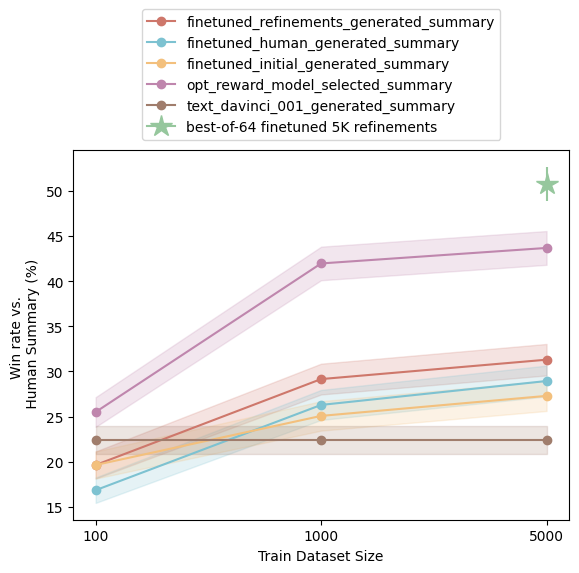

In [ ]:
params = {'font.size': 14, 'axes.labelsize': 14, 'legend.fontsize': 12, 'xtick.labelsize': 14, 'ytick.labelsize': 14}
matplotlib.rcParams.update(params)
matplotlib.pyplot.rcdefaults()

plot_refinements_comparison_of_finetuned_models(finetuning_methods_results_100, 
                                                finetuning_methods_results_1K,
                                                finetuning_methods_results_5K,
                                                )

In [ ]:
comparing_finetuned_results_100 = pd.read_json("/content/drive/MyDrive/training_language_models_with_language_feedback_at_scale_public/results/test_dataset_comparison_of_finetuned_models_100_with_ranking_per_summary.json", lines=True)

In [ ]:
finetuning_methods_to_evaluate_100 = [("finetuned_100_refinements_generated_summary_rank", "Davinci Finetuned on 100 Refinements"),
                                                         ("finetuned_100_human_generated_summary_rank", "Davinci Finetuned on 100 Human Summaries"), 
                                                         ("finetuned_100_initial_generated_summary_rank", "Davinci Finetuned on 100 Initial Summaries"), 
                                                         ("opt_reward_model_100_selected_summary_rank", "OPT Reward Model 13B - 100 Datapoints"), 
                                                         ("text_davinci_001_generated_summary_rank", "text-davinci-001"), 
                                                         ("ideal_human_summary_rank", "Human Summaries")]
finetuning_methods_results_100 = plot_win_rates_of_methods_compared_to_basline_method(comparing_finetuned_results_100, 
                                                                                                finetuning_methods_to_evaluate_100,
                                                                                                ["text_davinci_001_generated_summary_rank"]
                                                                                                )
finetuning_methods_results_100

,Win Rate Mean,Win Rate Standard Error
finetuned_100_refinements_generated_summary_rank_vs_text_davinci_001_generated_summary_rank,0.443410,0.018694
finetuned_100_human_generated_summary_rank_vs_text_davinci_001_generated_summary_rank,0.411891,0.018573
finetuned_100_initial_generated_summary_rank_vs_text_davinci_001_generated_summary_rank,0.487822,0.018756
opt_reward_model_100_selected_summary_rank_vs_text_davinci_001_generated_summary_rank,0.571633,0.018356
text_davinci_001_generated_summary_rank_vs_text_davinci_001_generated_summary_rank,0.500000,0.000000
ideal_human_summary_rank_vs_text_davinci_001_generated_summary_rank,0.792264,0.015366


In [ ]:
comparing_finetuned_results_1k = pd.read_json("/content/drive/MyDrive/training_language_models_with_language_feedback_at_scale_public/results/test_dataset_comparison_of_finetuned_models_1K_with_ranking_per_summary.json", lines=True)

In [ ]:
finetuning_comparision_validation_methods_to_evaluate_1k = [("finetuned_1K_refinements_generated_summary_rank", "Davinci Finetuned on 1K Refinements"),
                                                         ("finetuned_1K_human_generated_summary_rank", "Davinci Finetuned on 1K Human Summaries"), 
                                                         ("finetuned_1K_initial_generated_summary_rank", "Davinci Finetuned on 1K Initial Summaries"), 
                                                         ("opt_reward_model_1K_selected_summary_rank", "OPT Reward Model 13B - 1K Datapoints"), 
                                                         ("text_davinci_001_generated_summary_rank", "text-davinci-001"), 
                                                         ("ideal_human_summary_rank", "Human Summaries")]
finetuning_methods_results_1K = plot_win_rates_of_methods_compared_to_basline_method(comparing_finetuned_results_1k, 
                                                                                                finetuning_comparision_validation_methods_to_evaluate_1k,
                                                                                                ["text_davinci_001_generated_summary_rank"]
                                                                                                )
finetuning_methods_results_1K

,Win Rate Mean,Win Rate Standard Error
finetuned_1K_refinements_generated_summary_rank_vs_text_davinci_001_generated_summary_rank,0.539398,0.018702
finetuned_1K_human_generated_summary_rank_vs_text_davinci_001_generated_summary_rank,0.499284,0.018789
finetuned_1K_initial_generated_summary_rank_vs_text_davinci_001_generated_summary_rank,0.527937,0.018594
opt_reward_model_1K_selected_summary_rank_vs_text_davinci_001_generated_summary_rank,0.729943,0.016368
text_davinci_001_generated_summary_rank_vs_text_davinci_001_generated_summary_rank,0.500000,0.000000
ideal_human_summary_rank_vs_text_davinci_001_generated_summary_rank,0.760745,0.016096


In [ ]:
comparing_finetuned_results_5K = pd.read_json("/content/drive/MyDrive/training_language_models_with_language_feedback_at_scale_public/results/test_dataset_comparison_of_finetuned_models_5K_with_ranking_per_summary.json", lines=True)

In [ ]:
finetuning_methods_to_evaluate_5K = [("finetuned_5K_refinements_generated_summary_rank", "Davinci Finetuned on 5K Refinements"),
                                                         ("finetuned_5K_human_generated_summary_rank", "Davinci Finetuned on 5K Human Summaries"), 
                                                         ("finetuned_5K_initial_generated_summary_rank", "Davinci Finetuned on 5K Initial Summaries"), 
                                                         ("opt_reward_model_5K_selected_summary_rank", "OPT Reward Model 13B - 5K Datapoints"), 
                                                         ("text_davinci_001_generated_summary_rank", "text-davinci-001"), 
                                                         ("ideal_human_summary_rank", "Human Summaries")]
finetuning_methods_results_5K = plot_win_rates_of_methods_compared_to_basline_method(comparing_finetuned_results_5K, 
                                                                                                finetuning_methods_to_evaluate_5K,
                                                                                                 ["text_davinci_001_generated_summary_rank"]
                                                                                                )
finetuning_methods_results_5K

,Win Rate Mean,Win Rate Standard Error
finetuned_5K_refinements_generated_summary_rank_vs_text_davinci_001_generated_summary_rank,0.563037,0.018678
finetuned_5K_human_generated_summary_rank_vs_text_davinci_001_generated_summary_rank,0.520774,0.018854
finetuned_5K_initial_generated_summary_rank_vs_text_davinci_001_generated_summary_rank,0.558739,0.018643
opt_reward_model_5K_selected_summary_rank_vs_text_davinci_001_generated_summary_rank,0.732092,0.016434
text_davinci_001_generated_summary_rank_vs_text_davinci_001_generated_summary_rank,0.500000,0.000000
ideal_human_summary_rank_vs_text_davinci_001_generated_summary_rank,0.775072,0.015750


In [ ]:
def plot_refinements_comparison_of_finetuned_models(results_100: pd.DataFrame, 
                                                    results_1K: pd.DataFrame,
                                                    results_5K: pd.DataFrame,): 
  all_methods = [
        "finetuned_{}_refinements_generated_summary",
        "finetuned_{}_human_generated_summary",
        "finetuned_{}_initial_generated_summary",
        "opt_reward_model_{}_selected_summary",
        "text_davinci_001_generated_summary",
        "ideal_human_summary"
    ]
  all_results_mean = {
        "finetuned_refinements_generated_summary": [],
        "finetuned_human_generated_summary": [],
        "finetuned_initial_generated_summary": [],
        "opt_reward_model_selected_summary": [],
        "text_davinci_001_generated_summary": [],
        "ideal_human_summary": []
  }
  all_results_standard_error = {
        "finetuned_refinements_generated_summary": [],
        "finetuned_human_generated_summary": [],
        "finetuned_initial_generated_summary": [],
        "opt_reward_model_selected_summary": [],
        "text_davinci_001_generated_summary": [],
        "ideal_human_summary": []
  }
  
  all_results = [results_100, results_1K, results_5K]
  dataset_sizes = ["100", "1K", "5K"]

  for i in range(len(dataset_sizes)):
    result = all_results[i]
    for j, method_name in enumerate(all_methods):
      if j <= 4:
        method_name = method_name.format(dataset_sizes[i])
        column_name = method_name + "_rank_vs_text_davinci_001_generated_summary_rank"
        all_results_name = list(all_results_mean.keys())[j]
        all_results_mean[all_results_name].append(result["Win Rate Mean"][column_name])
        all_results_standard_error[all_results_name].append(result["Win Rate Standard Error"][column_name])
  fig, ax = plt.subplots()
  x_values = ["100", "1000", "5000"]
  #x_values = [100, 1000, 5000]
  for method_name in list(all_results_mean.keys())[:-1]:
    plt.plot(x_values, all_results_mean[method_name], label=method_name)
    ax.fill_between(x_values,
                    np.array(all_results_mean[method_name])-np.array(all_results_standard_error[method_name]),
                    np.array(all_results_mean[method_name])+np.array(all_results_standard_error[method_name]),
                    alpha=0.2)
  plt.xlabel("Train Dataset Size")
  plt.ylabel("Win rate vs. text-davinci-001")
  #plt.xscale("log")
  plt.legend()
  ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.4))
  plt.show()





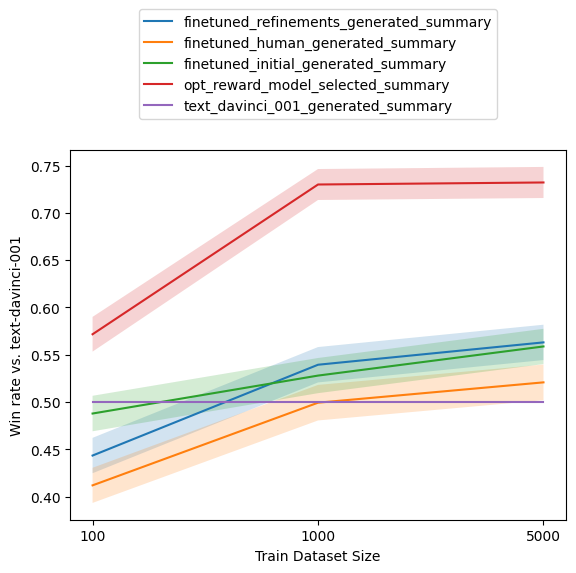

In [ ]:
#params = {'font.size': 12, 'axes.labelsize': 14, 'legend.fontsize': 20, 'xtick.labelsize': 12, 'ytick.labelsize': 12}
#matplotlib.rcParams.update(params)
matplotlib.pyplot.rcdefaults()

plot_refinements_comparison_of_finetuned_models(finetuning_methods_results_100, 
                                                finetuning_methods_results_1K,
                                                finetuning_methods_results_5K,
                                                )

## Log Likelihood on On-Distribution Valdiation Summaries

In [ ]:
def plot_log_likelihood_of_finetuned_models_on_validation() -> None: 
  dataset_sizes = [100,1000,5000]
  dataset_names = ["human_summaries", "refinements", "initial_summaries"]

  all_results_mean = {
        "human_summaries": [],
        "refinements": [],
        "initial_summaries": [],
  }
  all_results_standard_error = {
        "human_summaries": [],
        "refinements": [],
        "initial_summaries": [],
  }

  legend_names = {
        "human_summaries": "Finetuned on Human Summaries",
        "refinements": "Finetuned on Refinements",
        "initial_summaries": "Finetuned on Initial Summaries",
  }

  column_name = "average_log_probability_of_summary"
  data_path= "/content/drive/MyDrive/training_language_models_with_language_feedback_at_scale_public/results/validation_in_distribution_log_probs/"
  for dataset_name in dataset_names: 
    print(dataset_name)
    for dataset_size in dataset_sizes:
        path = os.path.join(data_path, "finetuned_on_{}_{}_validation_logprob_500.json".format(dataset_size, dataset_name))
        data = pd.read_json(path, lines=True)
        average_log_likelihood = -data[column_name].mean()
        standard_error = sem(data[column_name])
        all_results_mean[dataset_name].append(average_log_likelihood)
        all_results_standard_error[dataset_name].append(standard_error)


  fig, ax = plt.subplots()
  x_values = [100, 1000, 5000]
  for method_name in dataset_names:
    if "refinement" in method_name:
      color = colors[0]
    elif "human" in method_name: 
      color = colors[-3]
    elif "initial" in method_name:
      color = colors[1]
    else: 
      raise NotImplementedError()

    plt.plot(x_values, all_results_mean[method_name], label=legend_names[method_name], color=color, marker="o")
    ax.fill_between(x_values,
                    np.array(all_results_mean[method_name])-np.array(all_results_standard_error[method_name]),
                    np.array(all_results_mean[method_name])+np.array(all_results_standard_error[method_name]),
                    alpha=0.2, color=color)
  plt.xlabel("Train Dataset Size")
  plt.ylabel("Negative Log-Likelihood")
  plt.xscale("log")
  plt.yscale("log")
  plt.savefig(fig_output_path+ f"/finetuned_models_loss_scaling_validation_500.pdf", bbox_inches='tight')
  ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.4))
  plt.show()


human_summaries
refinements
initial_summaries


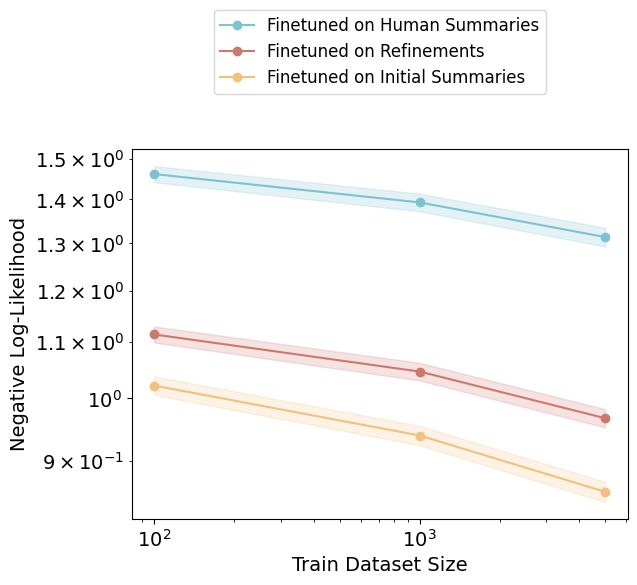

In [ ]:
params = {'font.size': 14, 'axes.labelsize': 14, 'legend.fontsize': 12, 'xtick.labelsize': 14, 'ytick.labelsize': 14}
matplotlib.rcParams.update(params)
plot_log_likelihood_of_finetuned_models_on_validation()

## Log Likelihoood of Davinci on Various Train datasets 1K

In [ ]:
davinci_log_prob_human = pd.read_json("/content/drive/MyDrive/training_language_models_with_language_feedback_at_scale_public/results/logprobs_of_train_data/davinci_logprob_human_summary_1000.jsonl", lines=True)
davinci_log_prob_refinements = pd.read_json("/content/drive/MyDrive/training_language_models_with_language_feedback_at_scale_public/results/logprobs_of_train_data/davinci_logprob_refinement_1000.jsonl", lines=True)
davinci_log_prob_initial = pd.read_json("/content/drive/MyDrive/training_language_models_with_language_feedback_at_scale_public/results/logprobs_of_train_data/davinci_logprob_initial_summary_1000.jsonl", lines=True)


In [ ]:
print("Davinci average log likelihood on initial summaries: {} +/- {}".format(- davinci_log_prob_initial["average_log_probability_of_summary"].mean(), sem(davinci_log_prob_initial["average_log_probability_of_summary"].tolist())))
print("Davinci average log likelihood on refinements: {} +/- {}".format(- davinci_log_prob_refinements["average_log_probability_of_summary"].mean(), sem(davinci_log_prob_refinements["average_log_probability_of_summary"].tolist())))
print("Davinci average log likelihood on human summaries: {} +/- {}".format(- davinci_log_prob_human["average_log_probability_of_summary"].mean(), sem(davinci_log_prob_human["average_log_probability_of_summary"].tolist())))

Davinci average log likelihood on initial summaries: 1.187913896629 +/- 0.012058727696111693
Davinci average log likelihood on refinements: 1.3727137448082 +/- 0.011646207185495201
Davinci average log likelihood on human summaries: 1.6114197035132 +/- 0.012241818353392227


## Forward and Backward KL

## Forward

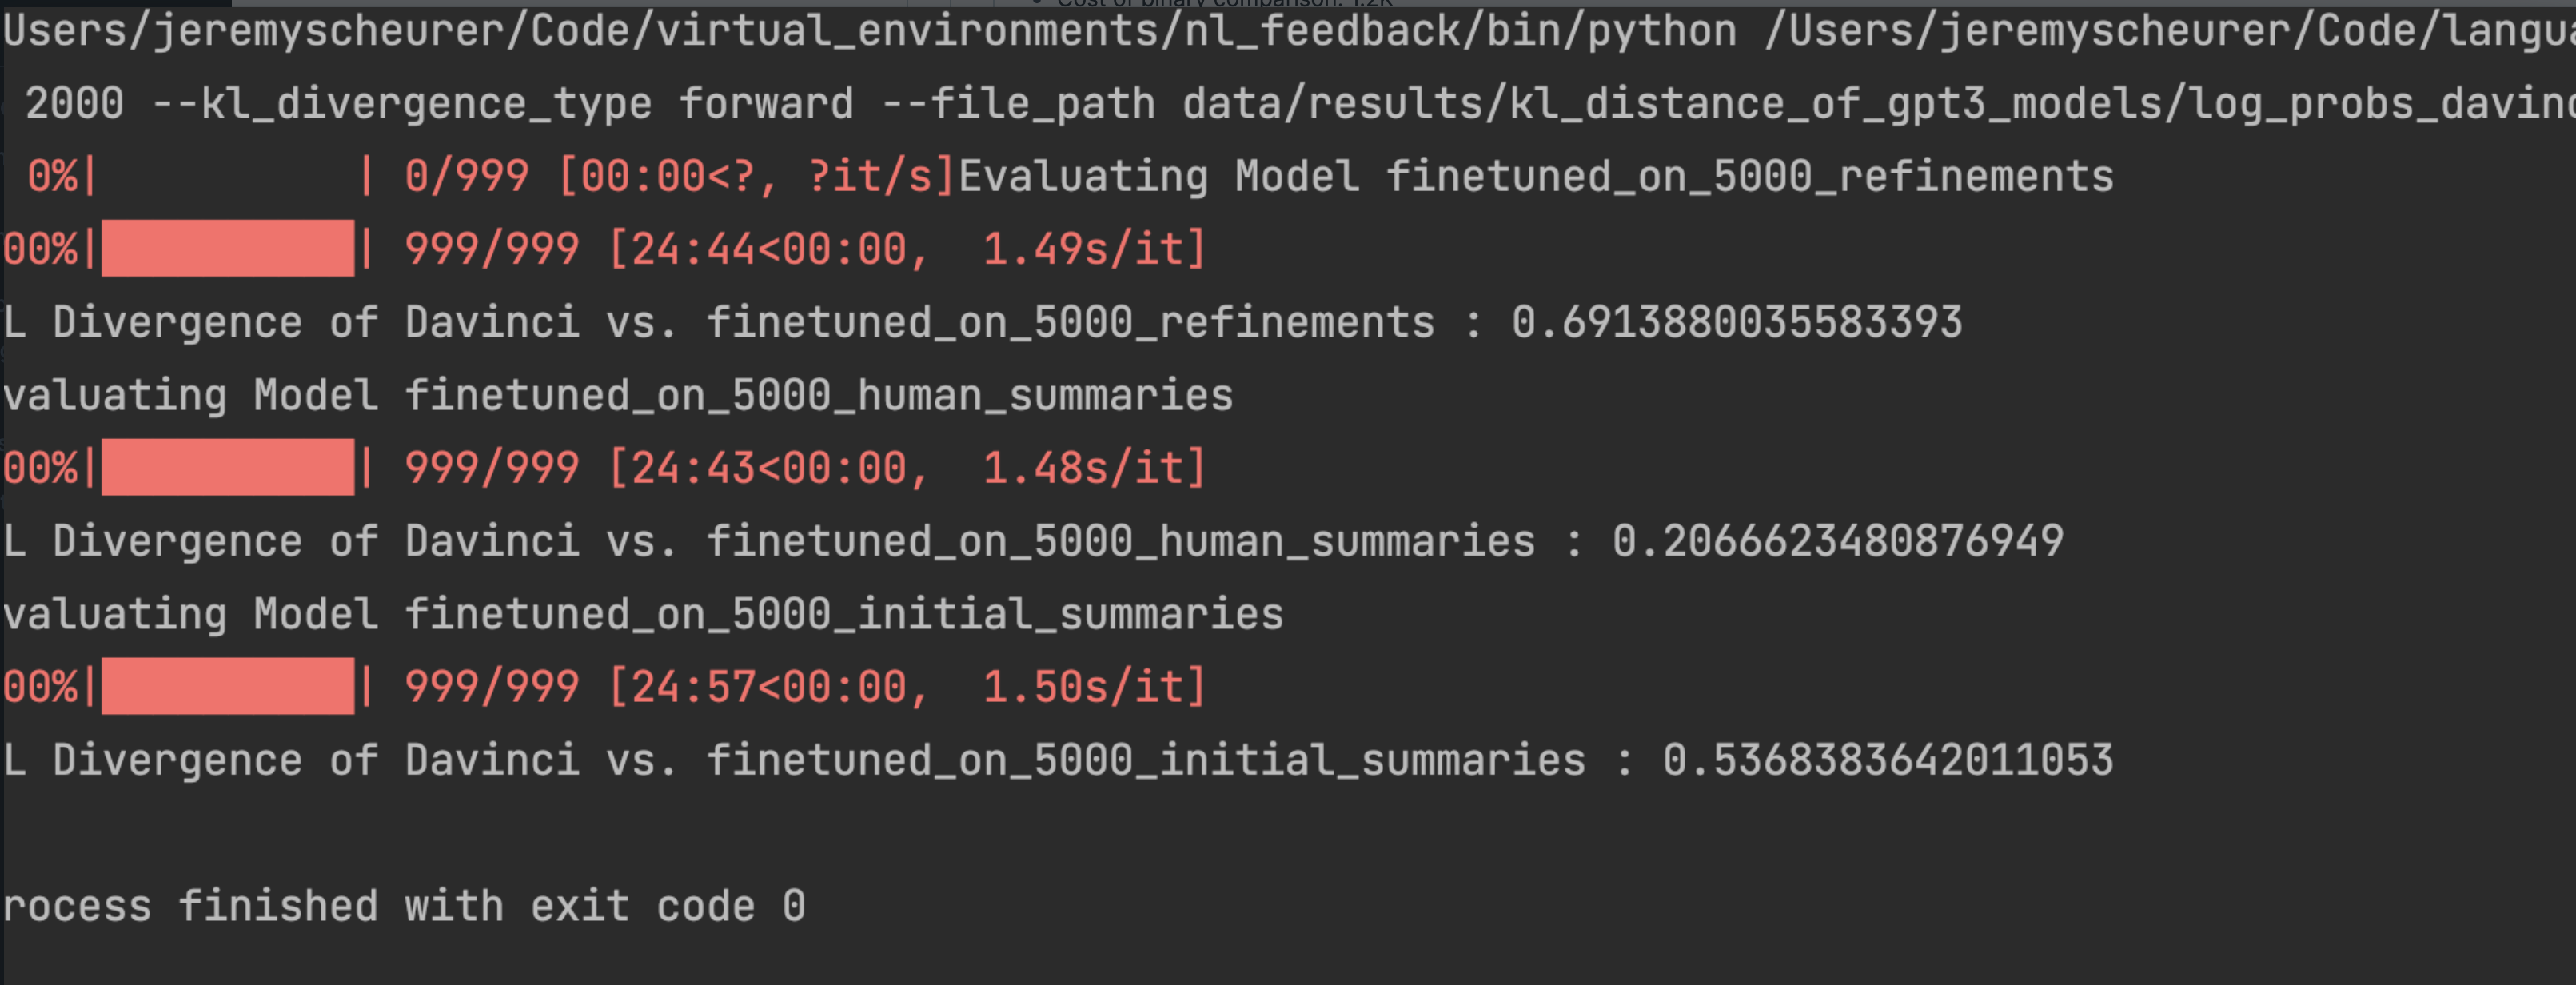

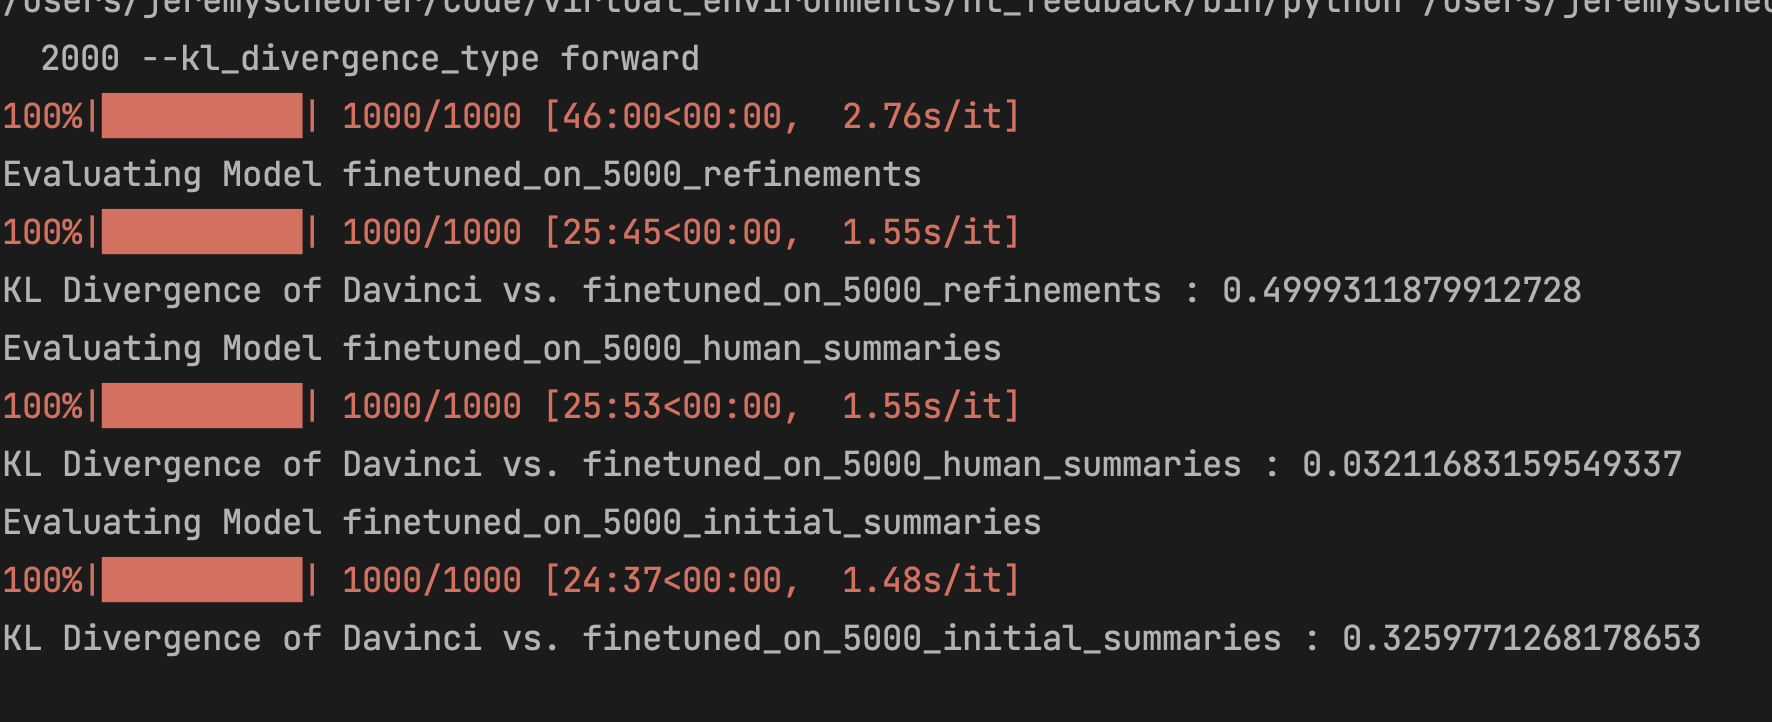

In [ ]:
refinement_values = [0.6914, 0.4999]
human_values = [0.2067, 0.0321]
initial_values = [0.5368,0.3260]


print("refinement_values: {} +/- {}".format(np.mean(refinement_values), sem(refinement_values)))
print("human_values: {} +/- {}".format(np.mean(human_values), sem(human_values)))
print("initial_values: {} +/- {}".format(np.mean(initial_values), sem(initial_values)))

refinement_values: 0.59565 +/- 0.09575
human_values: 0.11939999999999999 +/- 0.08729999999999999
initial_values: 0.4314 +/- 0.10540000000000001


## Backward

Round 1

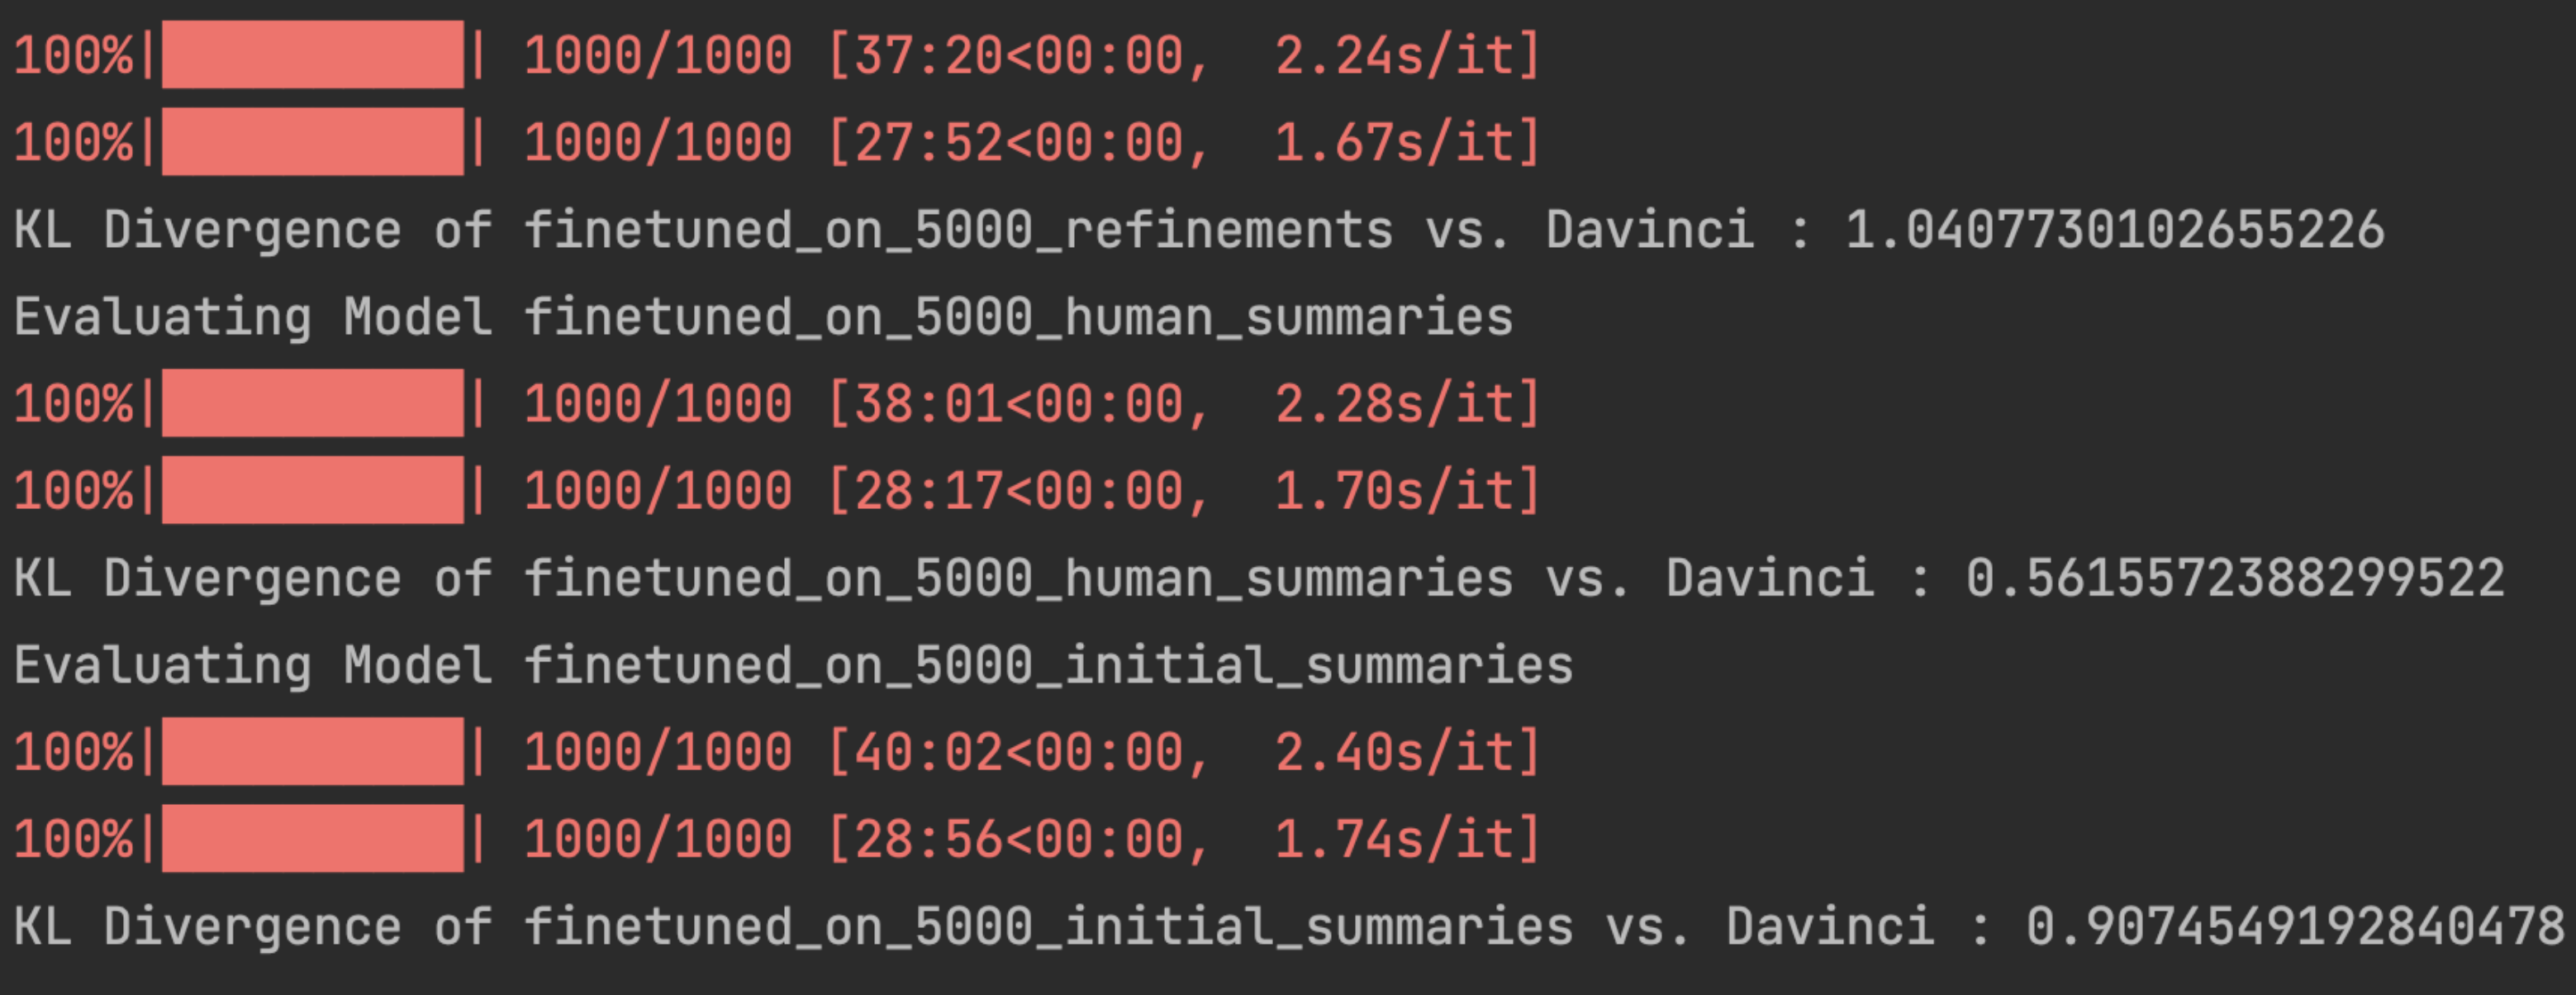

Round 2

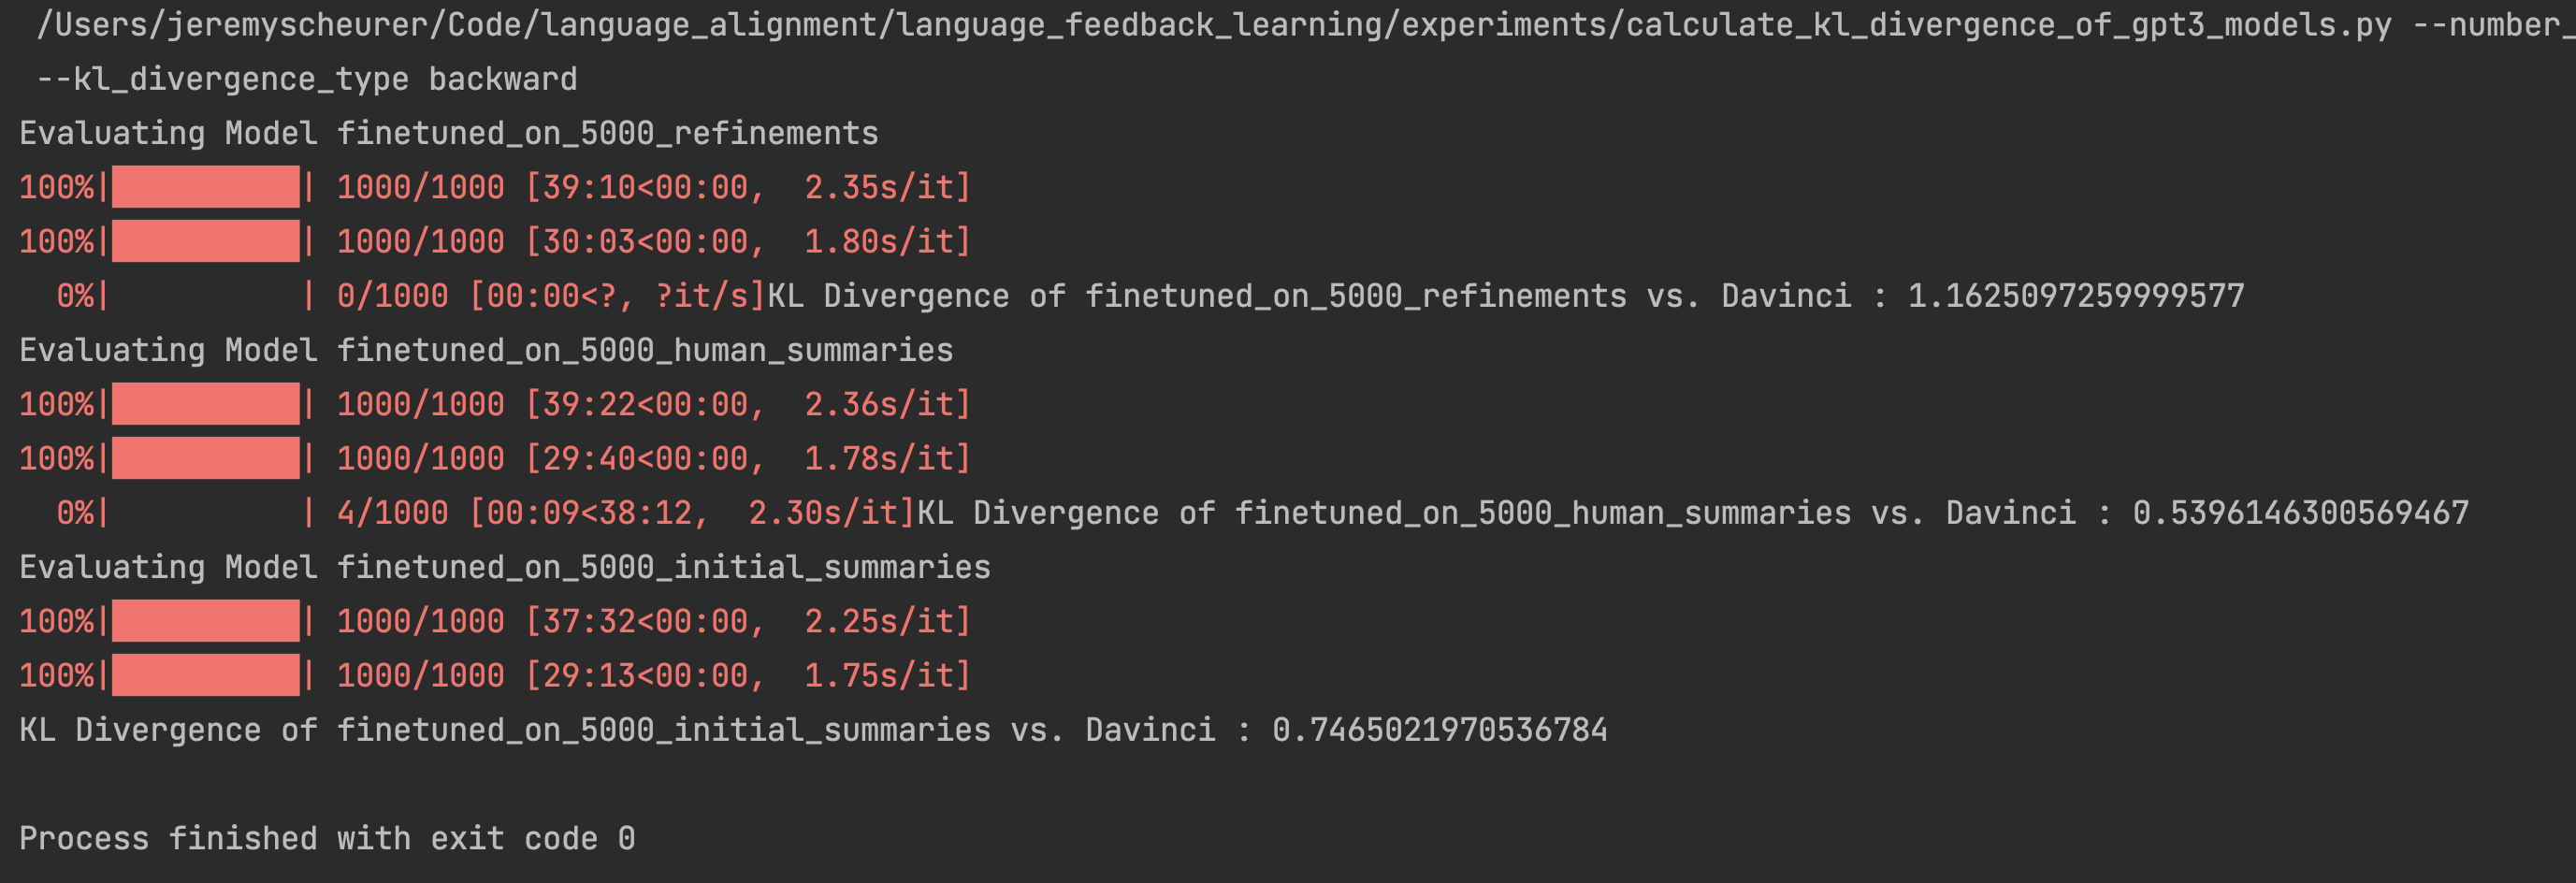

In [ ]:
refinement_values = [1.0408, 1.1625]
human_values = [0.5616,0.5396]
initial_values = [0.9075, 0.7465]


print("refinement_values: {} +/- {}".format(np.mean(refinement_values), sem(refinement_values)))
print("human_values: {} +/- {}".format(np.mean(human_values), sem(human_values)))
print("initial_values: {} +/- {}".format(np.mean(initial_values), sem(initial_values)))

refinement_values: 1.10165 +/- 0.060850000000000064
human_values: 0.5506 +/- 0.01100000000000001
initial_values: 0.827 +/- 0.08049999999999996


# Hyper Parameter Tuning Human Summaries - Perplexity

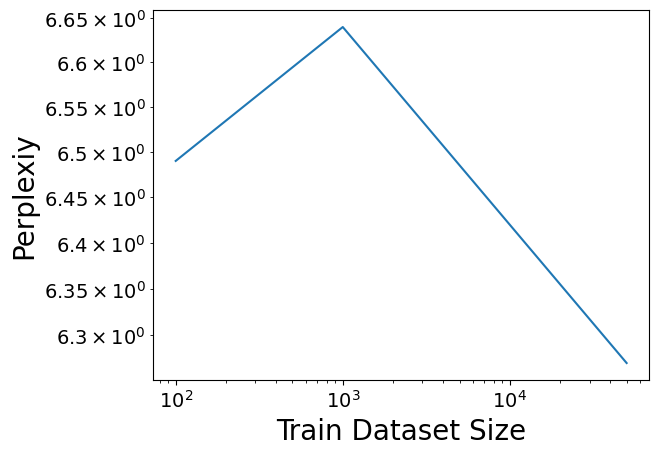

In [ ]:
dataset_sizes = [100, 1000, 50000]
perplexities = [6.49, 6.64, 6.27]

plt.plot(dataset_sizes, perplexities, )
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Train Dataset Size")
plt.ylabel("Perplexiy")
plt.show()

# Targeted word Removal

In [ ]:
def targeted_word_removal_results(model_names: List[str], max_number_of_offensive_words: int, max_number_of_forbidden_words: int, number_of_samples: int) -> None: 
 
  all_model_results = [] # List [[name, mean, sem], [name, mean, sem], ...]
  for i, model_name in enumerate(model_names): 
    result_dataframe = pd.read_json("/content/drive/MyDrive/training_language_models_with_language_feedback_at_scale_public/results/targeted_word_removal/{}_offensive_sentences_dataset_with_results.json".format(model_name))

    model_results_for_number_of_forbidden_words = []
    for number_of_forbidden_words in range(1, max_number_of_forbidden_words+1): 
      assert result_dataframe.shape[0] == number_of_samples
      for number_of_offensive_words in range(1, max_number_of_offensive_words+1): 
        if number_of_forbidden_words > number_of_offensive_words: 
          continue
        for sample_id in range(number_of_samples): 
          prediction = result_dataframe.iloc[sample_id]["{}_offensive_words_{}_forbidden_words_completion".format(number_of_offensive_words, number_of_forbidden_words)]
          target_sentence = result_dataframe.iloc[sample_id]["{}_offensive_words_{}_forbidden_words_target_sentence".format(number_of_offensive_words, number_of_forbidden_words)]
          target_sentence = target_sentence.split("You are")[1]

          sample_accuracy = int(target_sentence==prediction)
          model_results_for_number_of_forbidden_words.append(sample_accuracy)
    all_model_results.append([
        model_name,
        np.mean(model_results_for_number_of_forbidden_words),
        sem(model_results_for_number_of_forbidden_words),
    ])
    
  assert len(all_model_results) == len(model_names), len(all_model_results)
  print(all_model_results)
  

In [ ]:
#model_names = ["davinci","text-davinci-001", "curie","text-curie-001","babbage",  "text-babbage-001", "ada",  "text-ada-001",  ]
model_names = ["davinci", "text-davinci-001", "curie", "text-curie-001", "babbage", "text-babbage-001", "ada", "text-ada-001"]

targeted_word_removal_results(model_names, max_number_of_offensive_words=10, max_number_of_forbidden_words=3, number_of_samples=50)

[['davinci', 0.3851851851851852, 0.013249545310156891], ['text-davinci-001', 0.35777777777777775, 0.013050987412015751], ['curie', 0.08222222222222222, 0.007479238791132597], ['text-curie-001', 0.06, 0.006465968389975556], ['babbage', 0.017037037037037038, 0.0035233812276058017], ['text-babbage-001', 0.022222222222222223, 0.0040133575211823], ['ada', 0.011851851851851851, 0.0029464438063835753], ['text-ada-001', 0.016296296296296295, 0.0034472329685705056]]


# Iterative refinement

## Binary

In [ ]:
binary_comparison_results_round_1 = pd.read_json("/content/drive/MyDrive/training_language_models_with_language_feedback_at_scale_public/results/test_700_iterative_refinement_round_1_binary_comparison_win_rates.json", lines=True)

In [ ]:
print("Iterative Finetunign Round 1 average wins {} +/- {}".format(binary_comparison_results_round_1["iterative_finetuning_round_1_wins"].mean(), sem(binary_comparison_results_round_1["iterative_finetuning_round_1_wins"])))
print("Refinement Finetuning Baseline average wins {} +/- {}".format(binary_comparison_results_round_1["finetuned_on_refinements_round_1_baseline_wins"].mean(), sem(binary_comparison_results_round_1["finetuned_on_refinements_round_1_baseline_wins"])))


Iterative Finetunign Round 1 average wins 0.5315186246418339 +/- 0.018901184415556754
Refinement Finetuning Baseline average wins 0.4684813753581662 +/- 0.01890118441555675


In [ ]:
def plot_iterative_refinement_improvement(results: pd.DataFrame):
  fig, ax = plt.subplots()
  x_values = [100, 200]

  round_1_mean = binary_comparison_results_round_1["iterative_finetuning_round_1_wins"].mean()
  round_1_sem = sem(binary_comparison_results_round_1["iterative_finetuning_round_1_wins"])
  all_mean = [50, 100*round_1_mean]
  all_sem = [0, 100*round_1_sem]
  plt.plot(x_values, all_mean, label="Expert Iteration with Language Feedback",  marker="o", color=colors[2])
  ax.fill_between(x_values,
                  np.array(all_mean)-np.array(all_sem),
                  np.array(all_mean)+np.array(all_sem),
                  alpha=0.2, color=colors[2])
  plt.xlabel("Train Dataset Size")
  plt.ylabel("Win rate vs. \n Finetuning on Refinements")
  ax.set_xticks([100,200])
  plt.ylim((50))
  plt.savefig(fig_output_path+ f"/expert_iteration_comparison_100.pdf", bbox_inches='tight')
  ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.4))
  plt.show()


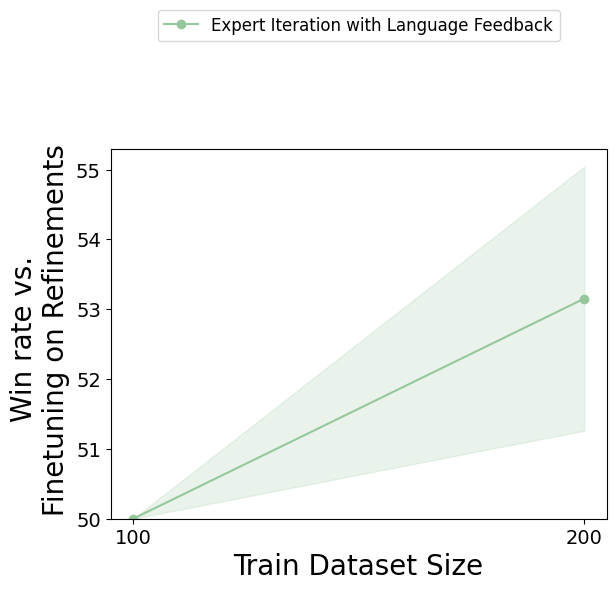

In [ ]:
plot_iterative_refinement_improvement(binary_comparison_results_round_1)

## Threeway

In [ ]:
iterative_refinement_round_1 = pd.read_json("/content/drive/MyDrive/training_language_models_with_language_feedback_at_scale_public/results/test_700_iterative_refinement_threeway_comparison_with_human_ranking_round_1.json", lines=True)
iterative_refinement_round_2 = pd.read_json("/content/drive/MyDrive/training_language_models_with_language_feedback_at_scale_public/results/test_700_iterative_refinement_threeway_comparison_with_human_ranking_round_2.json", lines=True)

In [ ]:
iterative_refinement_round_1_methods_to_evaluate = [("finetuned_on_refinements_round_1_baseline_rank", "Finetunined on 200 Refinements - Baseline"),
                                                         ("iterative_finetuning_round_1_200_rank", "Iterative Refinement Round 1"), 
                                                         ("iterative_further_finetuning_round_1_rank", "Iterative Refinement (further finetuning) Round 1")]
iterative_refinement_round_1_results = plot_win_rates_of_methods_compared_to_basline_method(iterative_refinement_round_1, 
                                                                                                iterative_refinement_round_1_methods_to_evaluate,
                                                                                                ["finetuned_on_refinements_round_1_baseline_rank"]
                                                                                                )
iterative_refinement_round_1_results

,Win Rate Mean,Win Rate Standard Error
finetuned_on_refinements_round_1_baseline_rank_vs_finetuned_on_refinements_round_1_baseline_rank,0.500000,0.000000
iterative_finetuning_round_1_200_rank_vs_finetuned_on_refinements_round_1_baseline_rank,0.488539,0.018934
iterative_further_finetuning_round_1_rank_vs_finetuned_on_refinements_round_1_baseline_rank,0.494269,0.018938


In [ ]:
iterative_refinement_round_2_methods_to_evaluate = [("finetuned_on_refinements_round_2_baseline_rank", "Finetunined on 200 Refinements - Baseline"),
                                                         ("iterative_finetuning_round_2_300_rank", "Iterative Refinement Round 1"), 
                                                         ("iterative_further_finetuning_round_2_rank", "Iterative Refinement (further finetuning) Round 1")]
iterative_refinement_round_2_results = plot_win_rates_of_methods_compared_to_basline_method(iterative_refinement_round_2, 
                                                                                                iterative_refinement_round_2_methods_to_evaluate,
                                                                                                ["finetuned_on_refinements_round_2_baseline_rank"]
                                                                                                )
iterative_refinement_round_2_results

,Win Rate Mean,Win Rate Standard Error
finetuned_on_refinements_round_2_baseline_rank_vs_finetuned_on_refinements_round_2_baseline_rank,0.500000,0.000000
iterative_finetuning_round_2_300_rank_vs_finetuned_on_refinements_round_2_baseline_rank,0.555874,0.018820
iterative_further_finetuning_round_2_rank_vs_finetuned_on_refinements_round_2_baseline_rank,0.508596,0.018936


In [ ]:
print(iterative_refinement_round_1["finetuned_on_refinements_round_1_baseline_rank"].mean())
print(iterative_refinement_round_1["iterative_finetuning_round_1_200_rank"].mean())
print(iterative_refinement_round_1["iterative_further_finetuning_round_1_rank"].mean())

1.9828080229226361
2.0286532951289398
1.988538681948424


In [ ]:
print(iterative_refinement_round_2["finetuned_on_refinements_round_2_baseline_rank"].mean())
print(iterative_refinement_round_2["iterative_finetuning_round_2_300_rank"].mean())
print(iterative_refinement_round_2["iterative_further_finetuning_round_2_rank"].mean())

2.0644699140401146
1.9004297994269341
2.0351002865329515


In [ ]:
def plot_threeway_iterative_refinement_improvement(results_round_1: pd.DataFrame, results_round_2: pd.DataFrame):
  fig, ax = plt.subplots()
  x_values = [100, 200, 300]

  round_1_iterative_further_finetuning_mean = results_round_1["Win Rate Mean"]["iterative_further_finetuning_round_1_rank_vs_finetuned_on_refinements_round_1_baseline_rank"]
  round_1_iterative_further_finetuning_sem = results_round_1["Win Rate Standard Error"]["iterative_further_finetuning_round_1_rank_vs_finetuned_on_refinements_round_1_baseline_rank"]
  round_2_iterative_further_finetuning_mean = results_round_2["Win Rate Mean"]["iterative_further_finetuning_round_2_rank_vs_finetuned_on_refinements_round_2_baseline_rank"]
  round_2_iterative_further_finetuning_sem = results_round_2["Win Rate Standard Error"]["iterative_further_finetuning_round_2_rank_vs_finetuned_on_refinements_round_2_baseline_rank"]

  round_1_iterative_mean = results_round_1["Win Rate Mean"]["iterative_finetuning_round_1_200_rank_vs_finetuned_on_refinements_round_1_baseline_rank"]
  round_1_iterative_sem = results_round_1["Win Rate Standard Error"]["iterative_finetuning_round_1_200_rank_vs_finetuned_on_refinements_round_1_baseline_rank"]
  round_2_iterative_mean = results_round_2["Win Rate Mean"]["iterative_finetuning_round_2_300_rank_vs_finetuned_on_refinements_round_2_baseline_rank"]
  round_2_iterative_sem = results_round_2["Win Rate Standard Error"]["iterative_finetuning_round_2_300_rank_vs_finetuned_on_refinements_round_2_baseline_rank"]


  all_mean_iterative_further_finetuning = [50, 100*round_1_iterative_further_finetuning_mean, 100*round_2_iterative_further_finetuning_mean]
  all_sem_iterative_further_finetuning = [0, 100*round_1_iterative_further_finetuning_sem, 100*round_2_iterative_further_finetuning_sem]

  all_mean_iterative = [50, 100*round_1_iterative_mean, 100*round_2_iterative_mean]
  all_sem_iterative = [0, 100*round_1_iterative_sem, 100*round_2_iterative_sem]

  plt.plot(x_values, all_mean_iterative_further_finetuning, label="Expert Iteration with Language Feedback (iterative finetuning)", marker="o")
  ax.fill_between(x_values,
                  np.array(all_mean_iterative_further_finetuning)-np.array(all_sem_iterative_further_finetuning),
                  np.array(all_mean_iterative_further_finetuning)+np.array(all_sem_iterative_further_finetuning),
                  alpha=0.2, )
  plt.plot(x_values, all_mean_iterative, label="Expert Iteration with Language Feedback (finetuning from scratch at each iteration)",  marker="o")
  ax.fill_between(x_values,
                  np.array(all_mean_iterative)-np.array(all_sem_iterative),
                  np.array(all_mean_iterative)+np.array(all_sem_iterative),
                  alpha=0.2)
  plt.xlabel("Train Dataset Size")
  plt.ylabel("Win rate vs. \n Finetuning on Refinements")
  ax.set_xticks([100,200,300])
  plt.ylim((45))
  plt.savefig(fig_output_path+ f"/expert_iteration_threeway_comparison.pdf", bbox_inches='tight')
  ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.4))
  plt.show()


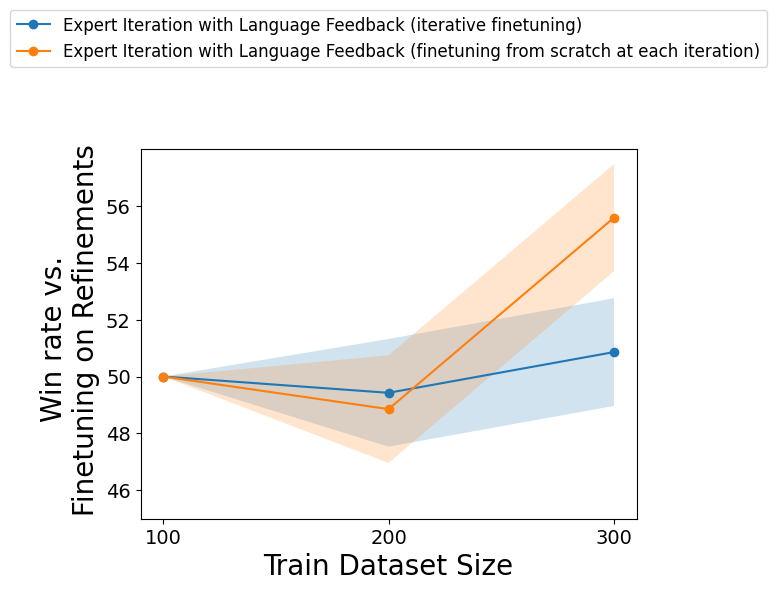

In [ ]:
plot_threeway_iterative_refinement_improvement(iterative_refinement_round_1_results, iterative_refinement_round_2_results)

# Additional Finetuning experiments

In [ ]:
additional_finetuning_results = pd.read_json("/content/drive/MyDrive/training_language_models_with_language_feedback_at_scale_public/results/test_700_additional_experiments_comparison_with_human_ranking.json", lines=True)
additional_finetuning_results.shape

(698, 33)

In [ ]:
additional_methods_to_evaluate = [("finetuned_5K_human_generated_summary_rank", "Davinci Finetuned on 5K Human Summaries"),
                                                         ("finetuned_5K_refinement_generated_summary_rank", "Davinci Finetuned on 5K Refinements"), 
                                                         ("finetuned_5K_feedback_and_refinement_generated_summary_rank", "Davinci Finetuned on 5K Feedback + Refinements"), 
                                                         ("opt_reward_model_5K_selected_summary_rank", "Best of 64 text-davinci-001 summaries"), 
                                                         ("opt_reward_model_5K_selected_finetuned_5K_refinement_rank", "Best of 64 refinements (from 5K finetuned)"), 
                                                         ("ideal_human_summary_rank", "Human Summaries")]
additional_methods_finetuning_results = plot_win_rates_of_methods_compared_to_basline_method(additional_finetuning_results, 
                                                                                                additional_methods_to_evaluate,
                                                                                                ["ideal_human_summary_rank"]
                                                                                                )
additional_methods_finetuning_results

,Win Rate Mean,Win Rate Standard Error
finetuned_5K_human_generated_summary_rank_vs_ideal_human_summary_rank,0.353868,0.018112
finetuned_5K_refinement_generated_summary_rank_vs_ideal_human_summary_rank,0.359599,0.018177
finetuned_5K_feedback_and_refinement_generated_summary_rank_vs_ideal_human_summary_rank,0.260745,0.016630
opt_reward_model_5K_selected_summary_rank_vs_ideal_human_summary_rank,0.450573,0.018832
opt_reward_model_5K_selected_finetuned_5K_refinement_rank_vs_ideal_human_summary_rank,0.507880,0.018923
ideal_human_summary_rank_vs_ideal_human_summary_rank,0.500000,0.000000


In [ ]:
def plot_additional_refinements(results_dataframe: pd.DataFrame): 
  win_rates = []
  standard_error = []
  methods = []
  current_colors = []

  win_rates.append(results_dataframe["Win Rate Mean"]["finetuned_5K_refinement_generated_summary_rank_vs_ideal_human_summary_rank"])
  standard_error.append(results_dataframe["Win Rate Standard Error"]["finetuned_5K_refinement_generated_summary_rank_vs_ideal_human_summary_rank"])
  methods.append("ILF: Finetuned on Refinements")
  current_colors.append(colors[0])


  win_rates.append(results_dataframe["Win Rate Mean"]["opt_reward_model_5K_selected_finetuned_5K_refinement_rank_vs_ideal_human_summary_rank"])
  standard_error.append(results_dataframe["Win Rate Standard Error"]["opt_reward_model_5K_selected_finetuned_5K_refinement_rank_vs_ideal_human_summary_rank"])
  methods.append("ILF + OPT-RM (best-of-64)")
  current_colors.append(colors[2])

  win_rates.append(results_dataframe["Win Rate Mean"]["opt_reward_model_5K_selected_summary_rank_vs_ideal_human_summary_rank"])
  standard_error.append(results_dataframe["Win Rate Standard Error"]["opt_reward_model_5K_selected_summary_rank_vs_ideal_human_summary_rank"])
  methods.append("OPT-RM best-of-64 FeedMe")
  current_colors.append(colors[-2])

  win_rates.append(results_dataframe["Win Rate Mean"]["finetuned_5K_human_generated_summary_rank_vs_ideal_human_summary_rank"])
  standard_error.append(results_dataframe["Win Rate Standard Error"]["finetuned_5K_human_generated_summary_rank_vs_ideal_human_summary_rank"])
  methods.append("Finetuned on 5K Human Summaries")
  current_colors.append(colors[-3])

  win_rates.append(results_dataframe["Win Rate Mean"]["finetuned_5K_feedback_and_refinement_generated_summary_rank_vs_ideal_human_summary_rank"])
  standard_error.append(results_dataframe["Win Rate Standard Error"]["finetuned_5K_feedback_and_refinement_generated_summary_rank_vs_ideal_human_summary_rank"])
  methods.append("Finetuned on 5K Feedback + Refinements")
  current_colors.append(orange)


  win_rates = [100*win_rate for win_rate in win_rates]
  standard_error = [100*sem for sem in standard_error]


  x_axis = range(results_dataframe.shape[0]-1)
  fig, ax = plt.subplots()
  print(x_axis)
  ax.bar(x_axis,win_rates , yerr=standard_error, color=current_colors)
  plt.ylabel("Win Rate vs. \n Human Summaries (%)")
  method_titles = [add_linebreaks(title) for title in methods]
  plt.xticks(x_axis, method_titles, rotation=0)
  #plt.ylim((50))
  plt.xticks(fontsize=10)
  plt.savefig(fig_output_path+ f"/additional_results_test_set.pdf", bbox_inches='tight')
  plt.show()

range(0, 5)


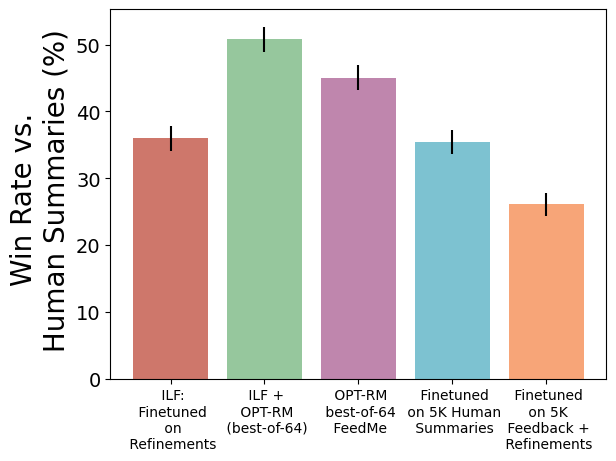

In [ ]:
#params = {'font.size': 10, 'axes.labelsize': 10, 'legend.fontsize': 20, 'xtick.labelsize': 10, 'ytick.labelsize': 12}
plot_additional_refinements(additional_methods_finetuning_results)

# Causal Respone evalaation


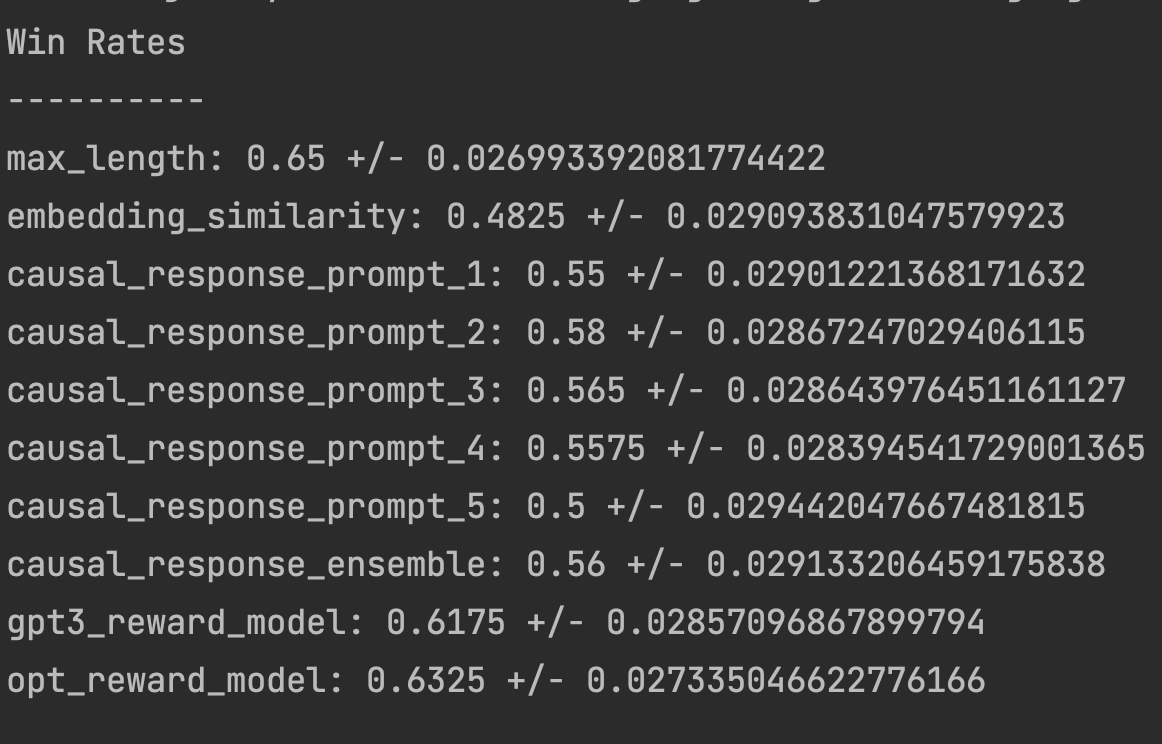